# The inclusion of people with disabilities in Europe

*Eurostat : often provides estimates based on samples and surveys, which may inflate certain percentages for some countries.*

In [2]:
import pandas as pd
import requests 
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

## Population General

Population by sex, age and disability status (only 2012, historical data)

In [2]:
# 1. Eurostat Data
dataset = "hlth_dpeh005"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# 2. Extract dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

# 3.
combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# 4. DataFrame 
df = pd.DataFrame(combinations, columns=dims)
df["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# 5. Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df[dim] = df[dim].map(labels)

df.head(5)

,freq,unit,hlth_pb,age,sex,geo,time,value
0,Annual,Thousand,Total,From 15 to 29 years,Total,European Union - 27 countries (2007-2013),2012,87227.6
1,Annual,Thousand,Total,From 15 to 29 years,Total,Belgium,2012,2052.9
2,Annual,Thousand,Total,From 15 to 29 years,Total,Bulgaria,2012,1271.6
3,Annual,Thousand,Total,From 15 to 29 years,Total,Czechia,2012,1933.8
4,Annual,Thousand,Total,From 15 to 29 years,Total,Denmark,2012,1022.1


In [3]:
df["hlth_pb"].unique()

array(['Total', 'Disabled', 'Not disabled'], dtype=object)

In [4]:
df["time"].unique()

array(['2012'], dtype=object)

In [5]:
to_remove = [
    "European Union - 27 countries (2007-2013)", 
    "European Economic Area (EEA18-1995, EEA28-2004, EEA30-2007, EEA31-2013, EEA30-2020)"
]

df = df[~df["geo"].isin(to_remove)]

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12694/1922687342.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="hlth_pb", y="value", palette="Set2")


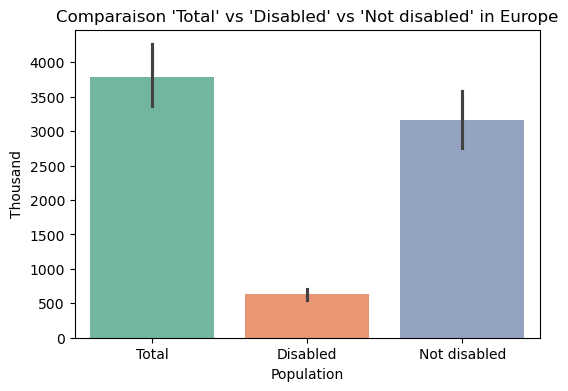

In [6]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="hlth_pb", y="value", palette="Set2")
plt.title("Comparaison 'Total' vs 'Disabled' vs 'Not disabled' in Europe")
plt.xlabel("Population")
plt.ylabel("Thousand")
plt.show()

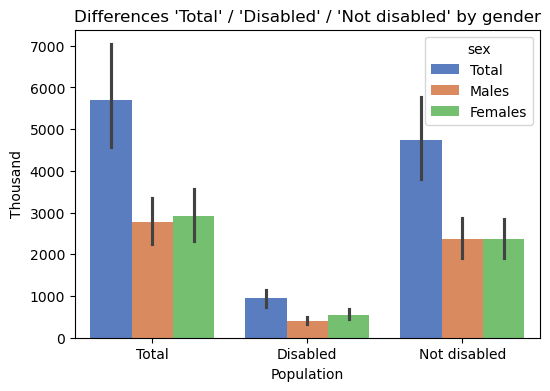

In [7]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="hlth_pb", y="value", hue="sex", palette="muted")
plt.title("Differences 'Total' / 'Disabled' / 'Not disabled' by gender")
plt.xlabel("Population")
plt.ylabel("Thousand")
plt.show()

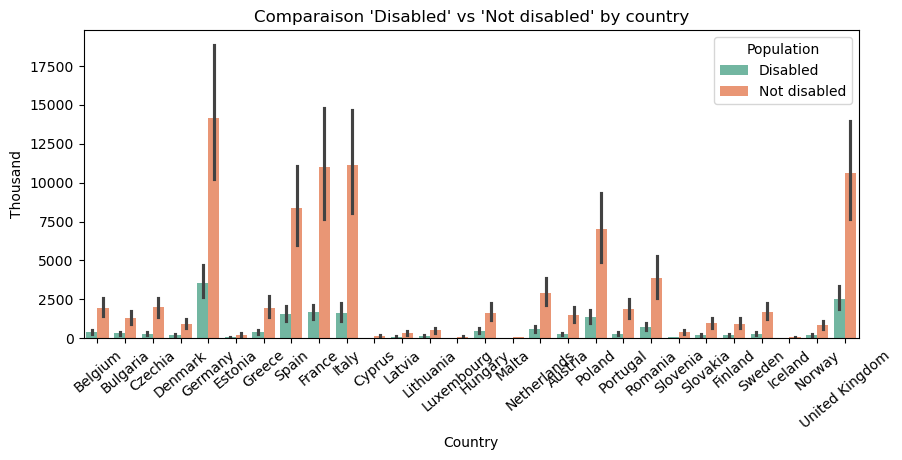

In [8]:
# Filter
df_sub = df[(df["hlth_pb"].isin(["Disabled", "Not disabled"]))]

plt.figure(figsize=(10,4))
sns.barplot(data=df_sub, x="geo", y="value", hue="hlth_pb", palette="Set2")
plt.title("Comparaison 'Disabled' vs 'Not disabled' by country")
plt.xlabel("Country")
plt.ylabel("Thousand")
plt.xticks(rotation=40)
plt.legend(title="Population")
plt.show()


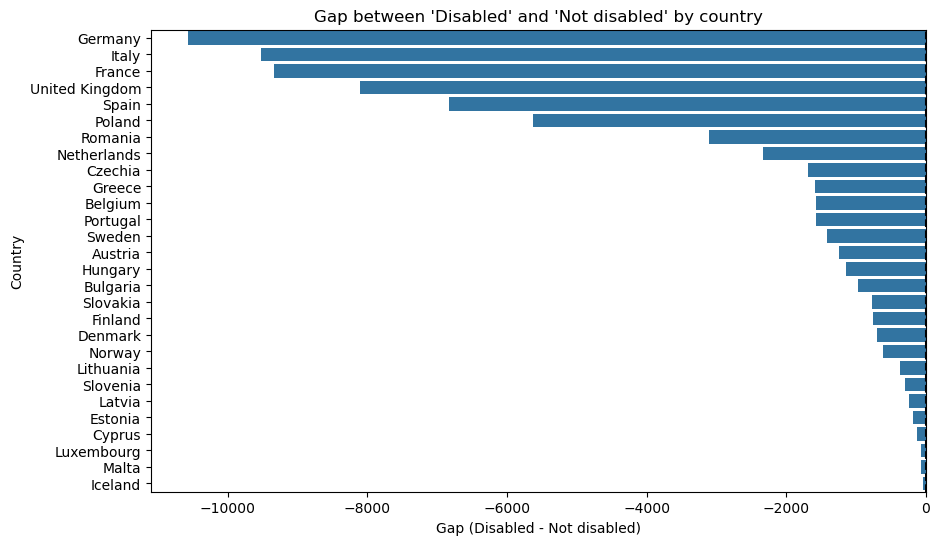

In [9]:
# Just Disabled / Not disabled
df_sub = df[(df["hlth_pb"].isin(["Disabled", "Not disabled"]))]

# Columns (pivot)
df_gap = df_sub.pivot_table(index="geo", columns="hlth_pb", values="value", aggfunc="mean").reset_index()

# Gap
df_gap["gap"] = df_gap["Disabled"] - df_gap["Not disabled"]

# Sort by gap (ascendant)
df_gap = df_gap.sort_values("gap", ascending=True)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_gap, x="gap", y="geo", dodge=False)
plt.axvline(0, color="black", linestyle="--")
plt.title("Gap between 'Disabled' and 'Not disabled' by country")
plt.xlabel("Gap (Disabled - Not disabled)")
plt.ylabel("Country")
plt.show()


/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12694/4141563237.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_inclusifs.sort_values("gap"), x="gap", y="geo", palette="Greens", ax=axes[0])
/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12694/4141563237.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_exclusifs.sort_values("gap"), x="gap", y="geo", palette="Reds", ax=axes[1])


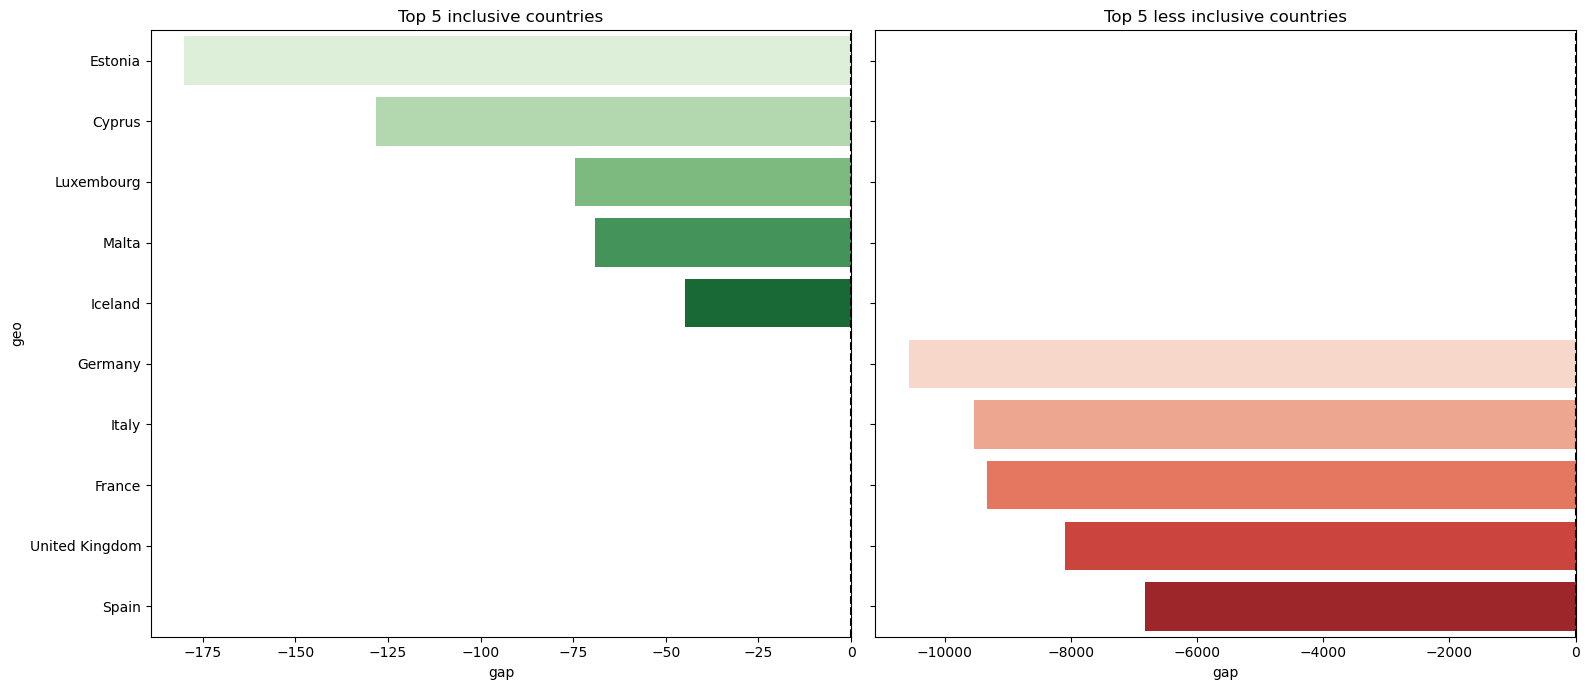

In [10]:
# Gap for more and less inclusive countries

hlth_vals = ["Disabled", "Not disabled"]

# Filter 
df_sub = df[df["hlth_pb"].isin(hlth_vals)]

# Pivot Disabled / Not disabled in columns
df_pivot = df_sub.pivot_table(index="geo", columns="hlth_pb", values="value", aggfunc="mean").dropna().reset_index()

# Gap
df_pivot["gap"] = df_pivot["Disabled"] - df_pivot["Not disabled"]

# Add column with absolut value 
df_pivot["abs_gap"] = df_pivot["gap"].abs()

# Top 5 inclusive = closest gap of 0
top5_inclusifs = df_pivot.nsmallest(5, "abs_gap")

# Top 5 exclusive = largest gap in absolute value
top5_exclusifs = df_pivot.nlargest(5, "abs_gap")

# Plot 
fig, axes = plt.subplots(1, 2, figsize=(16,7), sharey=True)

sns.barplot(data=top5_inclusifs.sort_values("gap"), x="gap", y="geo", palette="Greens", ax=axes[0])
axes[0].axvline(0, color="black", linestyle="--")
axes[0].set_title("Top 5 inclusive countries")

sns.barplot(data=top5_exclusifs.sort_values("gap"), x="gap", y="geo", palette="Reds", ax=axes[1])
axes[1].axvline(0, color="black", linestyle="--")
axes[1].set_title("Top 5 less inclusive countries")

plt.tight_layout()
plt.show()


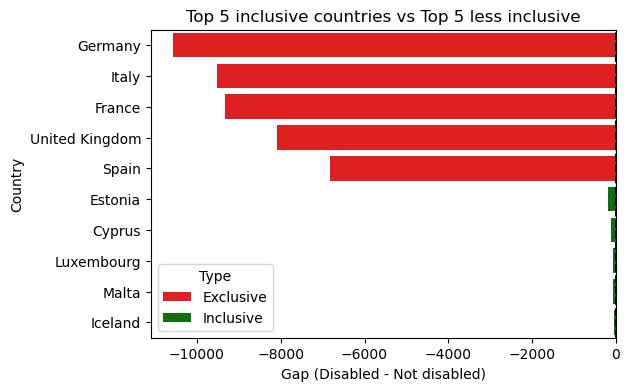

In [11]:
# In only one plot

hlth_vals = ["Disabled", "Not disabled"]

# Filter
df_sub = df[df["hlth_pb"].isin(hlth_vals)]

# Pivot
df_pivot = df_sub.pivot_table(index="geo", columns="hlth_pb", values="value", aggfunc="mean").dropna().reset_index()

# Gap
df_pivot["gap"] = df_pivot["Disabled"] - df_pivot["Not disabled"]

# Add column
df_pivot["abs_gap"] = df_pivot["gap"].abs()

# Top 5 inclusive and top 5 exclusive
top5_inclusifs = df_pivot.nsmallest(5, "abs_gap")
top5_exclusifs = df_pivot.nlargest(5, "abs_gap")

# Merge the both
top10 = pd.concat([top5_inclusifs, top5_exclusifs])
top10["type"] = ["Inclusive"]*5 + ["Exclusive"]*5

# Sort by gap
top10 = top10.sort_values("gap")

# Colors
palette = {"Inclusive":"green", "Exclusive":"red"}

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=top10, x="gap", y="geo", hue="type", dodge=False, palette=palette)
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Gap (Disabled - Not disabled)")
plt.ylabel("Country")
plt.title("Top 5 inclusive countries vs Top 5 less inclusive")
plt.legend(title="Type")
plt.show()


Gap close to 0 → people with disabilities are in a similar situation to able-bodied people → good inclusion.

Significant negative gap → people with disabilities are much fewer in number or less present in the indicator → disadvantage/exclusion.

In 2012 : 
- The less inclusive country for the disabled people : Germany 
- The most inclusive country : Iceland

In all European countries studied, people with disabilities are **systematically disadvantaged**.

No country has achieved real equality between people with and without disabilities. Even the most inclusive countries still have a significant gap, demonstrating that inclusion remains a **major challenge across Europe**.

## Education

Population by educational attainment level, sex, age and level of disability (activity limitation) (%)

In [2]:
df_education = pd.read_csv("/Users/lucielopez/Desktop/stuff/IRONHACK/PROJECT/FINAL PROJECT/DATA/education.csv")
df_education.head(2)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,lev_limit,Level of activity limitation,isced11,International Standard Classification of Education (ISCED 2011),sex,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:EDAT_LFS_9920(1.0),"Population by educational attainment level, se...",A,Annual,NONE,NaN,ED0-2,"Less than primary, primary and lower secondary...",F,...,AT,Austria,2022,NaN,38.9,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:EDAT_LFS_9920(1.0),"Population by educational attainment level, se...",A,Annual,NONE,NaN,ED0-2,"Less than primary, primary and lower secondary...",F,...,AT,Austria,2024,NaN,37.4,NaN,NaN,NaN,NaN,NaN


In [3]:
df_education.columns

Index(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
       'lev_limit', 'Level of activity limitation', 'isced11',
       'International Standard Classification of Education (ISCED 2011)',
       'sex', 'Sex', 'age', 'Age class', 'unit', 'Unit of measure', 'geo',
       'Geopolitical entity (reporting)', 'TIME_PERIOD', 'Time', 'OBS_VALUE',
       'Observation value', 'OBS_FLAG',
       'Observation status (Flag) V2 structure', 'CONF_STATUS',
       'Confidentiality status (flag)'],
      dtype='object')

In [4]:
df_education["geo"].unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT',
       'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'BA'],
      dtype=object)

In [5]:
df_education["STRUCTURE"].unique()

array(['dataflow'], dtype=object)

In [6]:
# Drop columns 

cols_to_drop = [
    "STRUCTURE", "freq", "STRUCTURE_NAME", "Level of activity limitation", 
    "sex", "age", "unit", "geo", 'Time', 
    'Observation value', 'CONF_STATUS', 'Confidentiality status (flag)'
]

df_edu_clean = df_education.drop(columns=cols_to_drop, errors="ignore")

df_edu_clean.head(2)

,STRUCTURE_ID,Time frequency,lev_limit,isced11,International Standard Classification of Education (ISCED 2011),Sex,Age class,Unit of measure,Geopolitical entity (reporting),TIME_PERIOD,OBS_VALUE,OBS_FLAG,Observation status (Flag) V2 structure
0,ESTAT:EDAT_LFS_9920(1.0),Annual,NONE,ED0-2,"Less than primary, primary and lower secondary...",Females,From 15 to 24 years,Percentage,Austria,2022,38.9,NaN,NaN
1,ESTAT:EDAT_LFS_9920(1.0),Annual,NONE,ED0-2,"Less than primary, primary and lower secondary...",Females,From 15 to 24 years,Percentage,Austria,2024,37.4,NaN,NaN


In [7]:
# Rename
df_edu_clean = df_edu_clean.rename(columns={"Geopolitical entity (reporting)": "geo"})
#df_edu_clean = df_edu_clean.rename(columns={"Level of activity limitation": "lev_limit"})

In [8]:
df_edu_clean["lev_limit"].unique()

array(['NONE', 'NRP', 'SEV', 'SM_SEV', 'SOME', 'TOTAL'], dtype=object)

In [9]:
df_edu_clean.head(3)

,STRUCTURE_ID,Time frequency,lev_limit,isced11,International Standard Classification of Education (ISCED 2011),Sex,Age class,Unit of measure,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,Observation status (Flag) V2 structure
0,ESTAT:EDAT_LFS_9920(1.0),Annual,NONE,ED0-2,"Less than primary, primary and lower secondary...",Females,From 15 to 24 years,Percentage,Austria,2022,38.9,NaN,NaN
1,ESTAT:EDAT_LFS_9920(1.0),Annual,NONE,ED0-2,"Less than primary, primary and lower secondary...",Females,From 15 to 24 years,Percentage,Austria,2024,37.4,NaN,NaN
2,ESTAT:EDAT_LFS_9920(1.0),Annual,NONE,ED0-2,"Less than primary, primary and lower secondary...",Females,From 15 to 24 years,Percentage,Belgium,2022,38.5,NaN,NaN


/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20012/3407158933.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


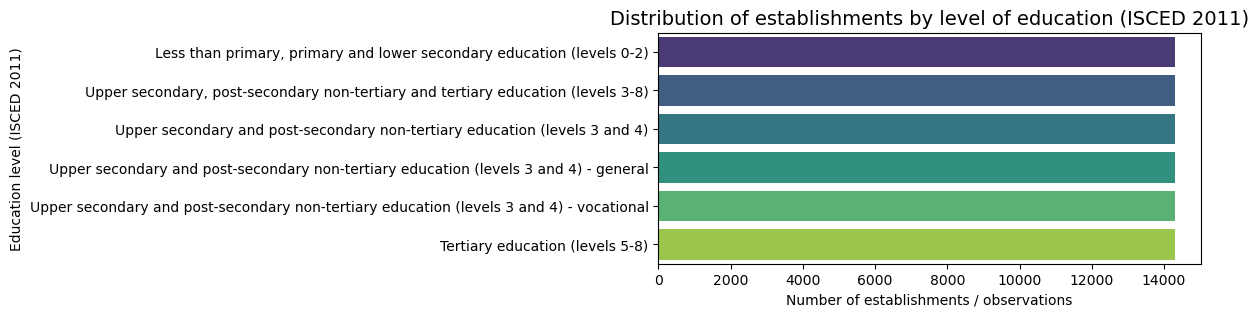

In [10]:
# Visualization

edu_counts = df_edu_clean["International Standard Classification of Education (ISCED 2011)"].value_counts()

# Barplot
plt.figure(figsize=(7,3))
sns.barplot(
    x=edu_counts.values, 
    y=edu_counts.index, 
    palette="viridis"
)
plt.title("Distribution of establishments by level of education (ISCED 2011)", fontsize=14)
plt.xlabel("Number of establishments / observations")
plt.ylabel("Education level (ISCED 2011)")
plt.show()

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20012/3730971495.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


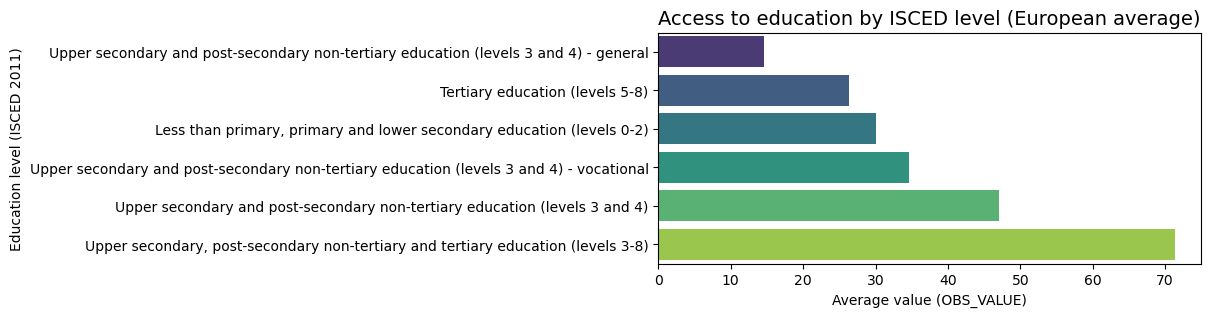

International Standard Classification of Education (ISCED 2011)
Upper secondary and post-secondary non-tertiary education (levels 3 and 4) - general       14.558103
Tertiary education (levels 5-8)                                                            26.313312
Less than primary, primary and lower secondary education (levels 0-2)                      30.043312
Upper secondary and post-secondary non-tertiary education (levels 3 and 4) - vocational    34.574866
Upper secondary and post-secondary non-tertiary education (levels 3 and 4)                 47.104184
Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)           71.367474
Name: OBS_VALUE, dtype: float64

In [11]:
# Aggregate actual values ​​by education level
edu_values = df_edu_clean.groupby("International Standard Classification of Education (ISCED 2011)")["OBS_VALUE"].mean().sort_values()


plt.figure(figsize=(7,3))
sns.barplot(
    x=edu_values.values,
    y=edu_values.index,
    palette="viridis"
)
plt.title("Access to education by ISCED level (European average)", fontsize=14)
plt.xlabel("Average value (OBS_VALUE)")
plt.ylabel("Education level (ISCED 2011)")
plt.show()

edu_values

→ **The actual measure associated with disabled/non-disabled people.**

In [13]:
df_edu_clean["lev_limit"].unique()

array(['NONE', 'NRP', 'SEV', 'SM_SEV', 'SOME', 'TOTAL'], dtype=object)

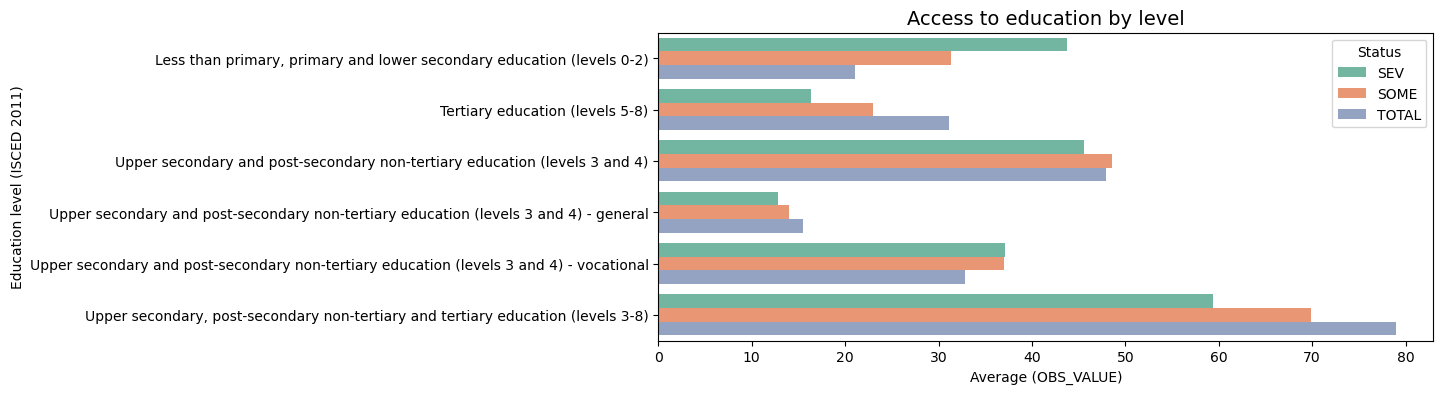

,International Standard Classification of Education (ISCED 2011),lev_limit,OBS_VALUE
0,"Less than primary, primary and lower secondary...",SEV,43.766248
1,"Less than primary, primary and lower secondary...",SOME,31.364765
2,"Less than primary, primary and lower secondary...",TOTAL,21.015857
3,Tertiary education (levels 5-8),SEV,16.350271
4,Tertiary education (levels 5-8),SOME,22.971984
5,Tertiary education (levels 5-8),TOTAL,31.103911
6,Upper secondary and post-secondary non-tertiar...,SEV,45.546734
7,Upper secondary and post-secondary non-tertiar...,SOME,48.608406
8,Upper secondary and post-secondary non-tertiar...,TOTAL,47.947812
9,Upper secondary and post-secondary non-tertiar...,SEV,12.826873


In [14]:
# 1. Disabled / Not disabled
df_sub = df_edu_clean[df_edu_clean["lev_limit"].isin(['SEV', 'SOME', 'TOTAL'])]

# 2. Average OBS_VALUE by ISCED 
edu_gap = df_sub.groupby(
    ["International Standard Classification of Education (ISCED 2011)", "lev_limit"]
)["OBS_VALUE"].mean().reset_index()

# 3. Grouped Barplot 
plt.figure(figsize=(10,4))
sns.barplot(
    data=edu_gap,
    x="OBS_VALUE", 
    y="International Standard Classification of Education (ISCED 2011)", 
    hue="lev_limit",
    palette="Set2"
)
plt.title("Access to education by level", fontsize=14)
plt.xlabel("Average (OBS_VALUE)")
plt.ylabel("Education level (ISCED 2011)")
plt.legend(title="Status")
plt.show()

edu_gap

In [15]:
# 1. Filter 
df_sub = df_edu_clean[df_edu_clean["lev_limit"].isin(['Severe','Some','Some or severe','Total'])]

# 2. Pivot : rows = ISCED, columns = Level of activity limitation, values = OBS_VALUE
df_pivot = df_sub.pivot_table(
    index="International Standard Classification of Education (ISCED 2011)",
    columns="lev_limit",
    values="OBS_VALUE",
    aggfunc='mean'
).fillna(0)

# 3. “Disabled” and “Not disabled”
df_pivot['Disabled'] = df_pivot['Severe'] + df_pivot['Some'] + df_pivot['Some or severe']
df_pivot['Not disabled'] = df_pivot['Total'] - df_pivot['Disabled']

# 4. Gap
df_pivot['gap'] = df_pivot['Disabled'] - df_pivot['Not disabled']

# 5. Barplot Gap
df_pivot = df_pivot.sort_values('gap')  # tri par gap
plt.figure(figsize=(10,6))
sns.barplot(x='gap', y=df_pivot.index, data=df_pivot, palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Gap (Disabled - Not disabled)')
plt.ylabel('Education level(ISCED 2011)')
plt.title("Estimated gap in access to education between Disabled and Not disabled by ISCED level")
plt.show()


KeyError: 'Severe'

In [16]:
df_pivot.head(5)

lev_limit
International Standard Classification of Education (ISCED 2011)


**Disabled** = people with severe or partial disabilities (Severe + Some + Some or Severe).

**Not disabled** = estimate: Total - Disabled.

**Gap** = Disabled – Not disabled → measures the inequality of access to education between people with and without disabilities.

People with disabilities generally have lower access to education than people without disabilities, with gaps more pronounced at certain ISCED levels. 

Levels with the most negative gaps indicate areas of weakest inclusion and where further efforts are needed to reduce inequalities : 
- Upper secondary, post-secondary non tertiary and tertiary education (levels 3-8)

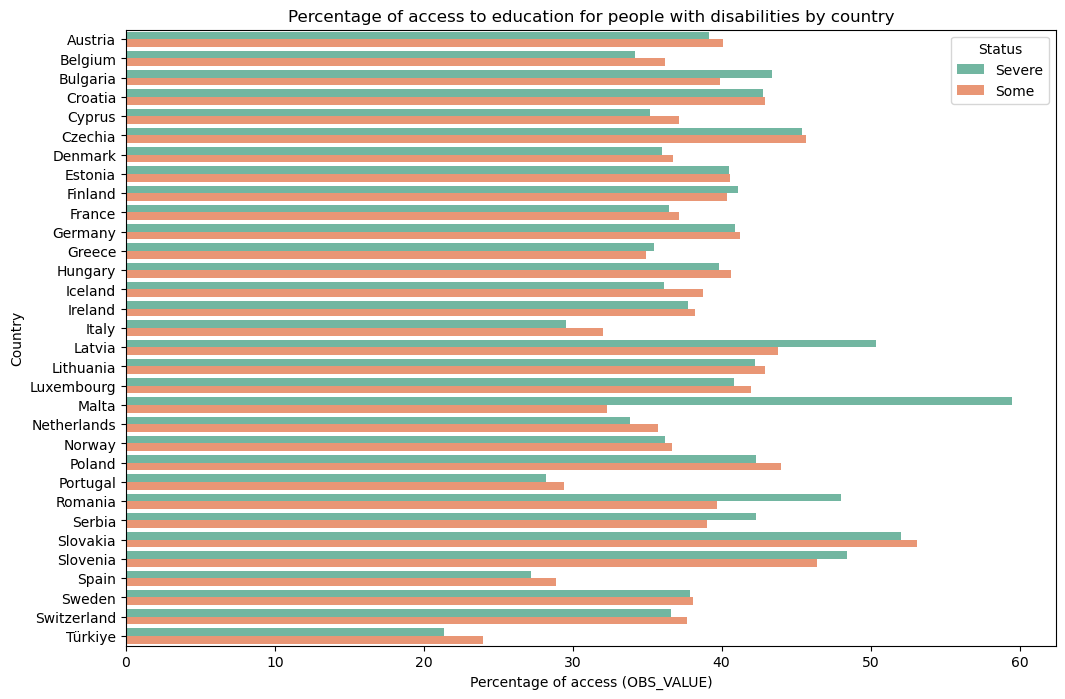

In [ ]:
# Filtrer uniquement les personnes handicapées
df_disabled = df_edu_clean[df_edu_clean["lev_limit"].isin(['Severe','Some'])]

# Moyenne OBS_VALUE par pays et type de limitation
edu_disabled = df_disabled.groupby(
    ["geo", "lev_limit"]
)["OBS_VALUE"].mean().reset_index()

# Barplot
plt.figure(figsize=(12,8))
sns.barplot(
    data=edu_disabled,
    x="OBS_VALUE",
    y="geo",
    hue="lev_limit",
    palette="Set2"
)
plt.title("Percentage of access to education for people with disabilities by country")
plt.xlabel("Percentage of access (OBS_VALUE)")
plt.ylabel("Country")
plt.legend(title="Status")
plt.show()

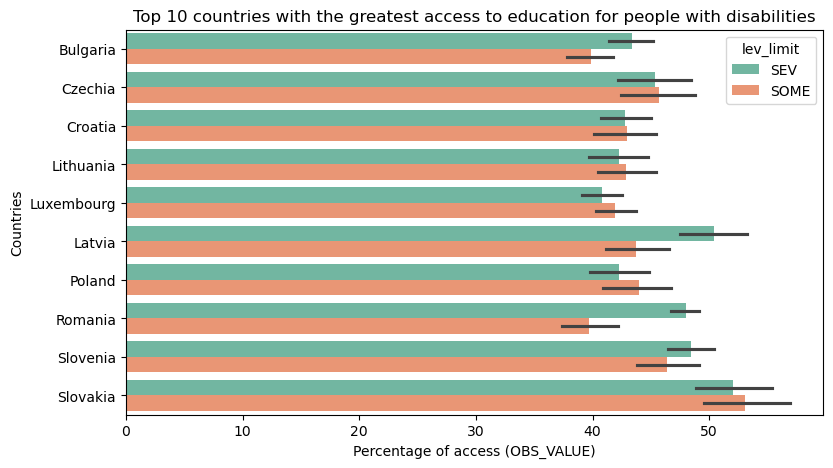

In [31]:
# Filter 
df_disabled = df_edu_clean[df_edu_clean["lev_limit"].isin(['SEV','SOME', 'SM_SOME'])]

# Average OBS_VALUE country
country_avg = df_disabled.groupby("geo")["OBS_VALUE"].mean().reset_index()

# Top 10 countries with greatest access
top10_countries = country_avg.nlargest(10, "OBS_VALUE")

# Filter df_disabled to keep 10 countries
df_top10 = df_disabled[df_disabled["geo"].isin(top10_countries["geo"])]

# Barplot
plt.figure(figsize=(9,5))
sns.barplot(
    data=df_top10,
    x="OBS_VALUE",
    y="geo",
    hue="lev_limit",
    palette="Set2"
)


plt.title("Top 10 countries with the greatest access to education for people with disabilities")
plt.xlabel("Percentage of access (OBS_VALUE)")
plt.ylabel("Countries")
plt.show()


In [32]:
# Moyenne par pays pour les niveaux choisis
country_avg = df_disabled.groupby("geo")["OBS_VALUE"].mean().reset_index()

# Top 10 pays avec le meilleur accès
top5_countries = country_avg.nlargest(5, "OBS_VALUE")

# Filtrer le dataframe pour garder uniquement ces 10 pays
df_top5 = df_disabled[df_disabled["geo"].isin(top5_countries["geo"])]

# Créer un tableau résumé
tableau = df_top5.pivot_table(
    index="geo",
    columns="lev_limit",
    values="OBS_VALUE",
    aggfunc="mean"
).reset_index()

# Afficher le tableau
print(tableau)


lev_limit       geo        SEV       SOME
0           Czechia  45.384131  45.695495
1            Latvia  50.388163  43.750872
2            Poland  42.282586  44.006542
3          Slovakia  52.032787  53.085627
4          Slovenia  48.438346  46.367890


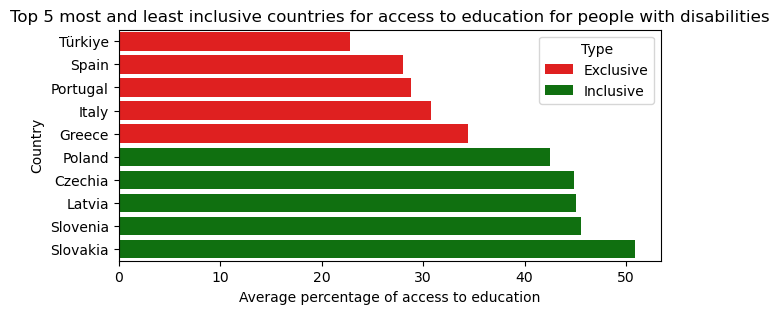

In [30]:
# Filter disabled people
df_disabled = df_edu_clean[df_edu_clean["lev_limit"].isin(['SEV','SOME','SM_SEV'])]

# Average OBS_VALUE by country
country_avg = df_disabled.groupby("geo")["OBS_VALUE"].mean().reset_index()

# Top 5 inclusive and top 5 exclusive
top5_inclusifs = country_avg.nlargest(5, "OBS_VALUE")
top5_exclusifs = country_avg.nsmallest(5, "OBS_VALUE")

# Column Type
top5_inclusifs['Type'] = 'Inclusive'
top5_exclusifs['Type'] = 'Exclusive'

# Merge 
top10 = pd.concat([top5_inclusifs, top5_exclusifs])

# Sort
top10 = top10.sort_values("OBS_VALUE")

# Barplot 
plt.figure(figsize=(7,3))
sns.barplot(
    data=top10,
    x="OBS_VALUE",
    y="geo",
    hue="Type",
    dodge=False,
    palette={"Inclusive":"green", "Exclusive":"red"}
)
plt.xlabel("Average percentage of access to education")
plt.ylabel("Country")
plt.title("Top 5 most and least inclusive countries for access to education for people with disabilities")
plt.legend(title="Type")
plt.show()

In [37]:

top5_inclusifs, top5_exclusifs

(         geo  OBS_VALUE       Type
 26  Slovakia  50.900504  Inclusive
 27  Slovenia  45.532316  Inclusive
 16    Latvia  45.059244  Inclusive
 5    Czechia  44.854692  Inclusive
 22    Poland  42.518695  Inclusive,
          geo  OBS_VALUE       Type
 31   Türkiye  22.794444  Exclusive
 28     Spain  27.991286  Exclusive
 23  Portugal  28.764917  Exclusive
 15     Italy  30.785054  Exclusive
 11    Greece  34.426058  Exclusive)

Slovakia appears to be the country with the highest average percentage of access to education for people with disabilities, but it is important to note that these figures represent an average of the different categories of limitation and that gaps may remain between levels of disability and types of education.

In [ ]:
country_avg.sort_values("OBS_VALUE", ascending=False).head(10)

,geo,OBS_VALUE
26,Slovakia,50.900504
27,Slovenia,45.532316
16,Latvia,45.059244
5,Czechia,44.854692
22,Poland,42.518695
17,Lithuania,42.273236
3,Croatia,42.174436
24,Romania,41.517131
18,Luxembourg,41.235655
10,Germany,40.615718


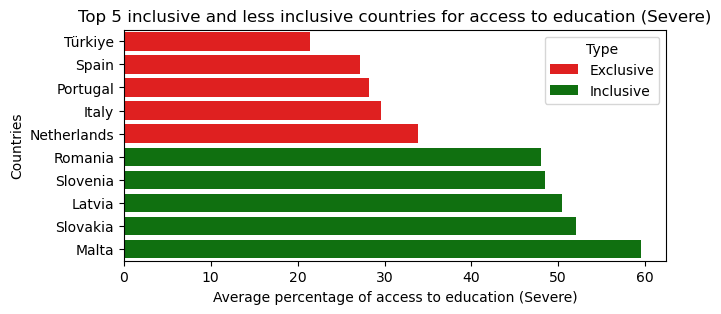

In [ ]:
# Severe only 

# Filter Severe
df_severe = df_edu_clean[df_edu_clean["lev_limit"] == 'Severe']

# Average OBS_VALUE by country
country_avg_severe = df_severe.groupby("geo")["OBS_VALUE"].mean().reset_index()

# Top 5 inclusive countries
top5_inclusifs_severe = country_avg_severe.nlargest(5, "OBS_VALUE")

# Top 5 less inclusive countries
top5_exclusifs_severe = country_avg_severe.nsmallest(5, "OBS_VALUE")

# Column Type
top5_inclusifs_severe['Type'] = 'Inclusive'
top5_exclusifs_severe['Type'] = 'Exclusive'

# Merge
top10_severe = pd.concat([top5_inclusifs_severe, top5_exclusifs_severe])
top10_severe = top10_severe.sort_values("OBS_VALUE")

# Barplot
plt.figure(figsize=(7,3))
sns.barplot(
    data=top10_severe,
    x="OBS_VALUE",
    y="geo",
    hue="Type",
    dodge=False,
    palette={"Inclusive":"green", "Exclusive":"red"}
)
plt.xlabel("Average percentage of access to education (Severe)")
plt.ylabel("Countries")
plt.title("Top 5 inclusive and less inclusive countries for access to education (Severe)")
plt.legend(title="Type")
plt.show()

**→ Inclusion varies depending on the type of disability**

Young people neither in employment nor in education and training by sex, age and level of disability (activity limitation) 2022 - 2024

*NEET = Neither in employment nor in education and training*

In [38]:
# 1. Eurostat Data
dataset = "edat_lfse_39"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# 2. Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# 4. DataFrame 
df_edu_young = pd.DataFrame(combinations, columns=dims)
df_edu_young["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# 5. Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_edu_young[dim] = df_edu_young[dim].map(labels)

df_edu_young#.head(3)

,freq,lev_limit,sex,age,unit,geo,time,value
0,Annual,Total,Total,From 15 to 24 years,Percentage,European Union - 27 countries (from 2020),2022,9.5
1,Annual,Total,Total,From 15 to 24 years,Percentage,European Union - 27 countries (from 2020),2024,9.2
2,Annual,Total,Total,From 15 to 24 years,Percentage,Euro area – 20 countries (from 2023),2022,9.4
3,Annual,Total,Total,From 15 to 24 years,Percentage,Euro area – 20 countries (from 2023),2024,9.2
4,Annual,Total,Total,From 15 to 24 years,Percentage,Belgium,2022,7.1
...,...,...,...,...,...,...,...,...
10075,Annual,No response,Females,From 25 to 34 years,Percentage,Bosnia and Herzegovina,2024,40.0
10076,Annual,No response,Females,From 25 to 34 years,Percentage,Serbia,2022,NaN
10077,Annual,No response,Females,From 25 to 34 years,Percentage,Serbia,2024,NaN
10078,Annual,No response,Females,From 25 to 34 years,Percentage,Türkiye,2022,NaN


In [39]:
df_edu_young["age"].unique()

array(['From 15 to 24 years', 'From 15 to 29 years',
       'From 15 to 34 years', 'From 18 to 24 years',
       'From 18 to 29 years', 'From 20 to 34 years',
       'From 25 to 29 years', 'From 25 to 34 years'], dtype=object)

In [40]:
# Remove
exclude_geo = [
    "European Union - 27 countries (from 2020)",
    "Euro area – 20 countries (from 2023)"
]

df_edu_young_clean = df_edu_young[~df_edu_young["geo"].isin(exclude_geo)]


# Age
to_remove_age_neet = [
    'From 15 to 24 years',
    'From 18 to 24 years',
    'From 25 to 29 years',
    'From 20 to 34 years',
    'From 18 to 29 years'
]
df_edu_young_clean = df_edu_young[~df_edu_young["age"].isin(to_remove_age_neet)]

In [41]:
df_edu_young_clean

,freq,lev_limit,sex,age,unit,geo,time,value
70,Annual,Total,Total,From 15 to 29 years,Percentage,European Union - 27 countries (from 2020),2022,11.7
71,Annual,Total,Total,From 15 to 29 years,Percentage,European Union - 27 countries (from 2020),2024,11.1
72,Annual,Total,Total,From 15 to 29 years,Percentage,Euro area – 20 countries (from 2023),2022,11.6
73,Annual,Total,Total,From 15 to 29 years,Percentage,Euro area – 20 countries (from 2023),2024,11.1
74,Annual,Total,Total,From 15 to 29 years,Percentage,Belgium,2022,9.3
...,...,...,...,...,...,...,...,...
10075,Annual,No response,Females,From 25 to 34 years,Percentage,Bosnia and Herzegovina,2024,40.0
10076,Annual,No response,Females,From 25 to 34 years,Percentage,Serbia,2022,NaN
10077,Annual,No response,Females,From 25 to 34 years,Percentage,Serbia,2024,NaN
10078,Annual,No response,Females,From 25 to 34 years,Percentage,Türkiye,2022,NaN


In [42]:
# Delete Bosnia and Herzegovina because NaN
df_edu_young_clean = df_edu_young_clean[df_edu_young_clean["geo"] != "Bosnia and Herzegovina"]

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20012/4100929712.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


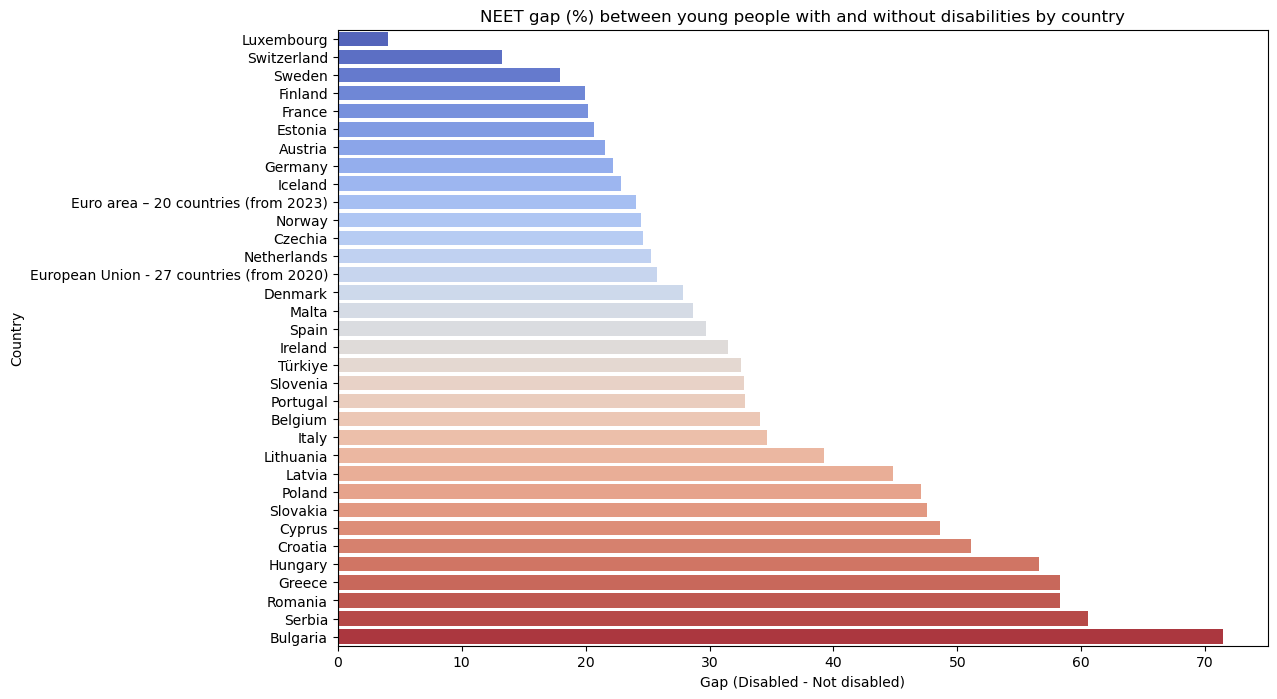

Top 5 most inclusive countries (smallest gap):
Disability_status          geo   Disabled  Not disabled        Gap
20                  Luxembourg  12.221429      8.158824   4.062605
32                 Switzerland  21.829630      8.577778  13.251852
31                      Sweden  22.733333      4.777778  17.955556
10                     Finland  26.901852      6.955556  19.946296
11                      France  32.294444     12.072222  20.222222
Top 5 least inclusive countries (highest gap) :
Disability_status       geo   Disabled  Not disabled        Gap
14                  Hungary  66.675472     10.127778  56.547694
13                   Greece  75.822727     17.527778  58.294949
26                  Romania  78.398000     20.100000  58.298000
27                   Serbia  76.747170     16.233333  60.513836
2                  Bulgaria  86.161538     14.688889  71.472650


In [43]:
# Gap / Inclusion analysis = Comparer youngest Disabled (Severe, Some, Some or severe) vs Not disabled (None) by country

# Keep useful columns
df_gap = df_edu_young_clean[["geo", "lev_limit", "value"]].copy()

# Group by level of disability
df_gap["Disability_status"] = df_gap["lev_limit"].replace({
    "Severe": "Disabled",
    "Some": "Disabled",
    "Some or severe": "Disabled",
    "None": "Not disabled"
})

# Disabled / Not disabled
df_gap = df_gap[df_gap["Disability_status"].isin(["Disabled", "Not disabled"])]

# Average by country and status
df_grouped = df_gap.groupby(["geo", "Disability_status"])["value"].mean().reset_index()

# Pivot for gap
df_pivot = df_grouped.pivot(index="geo", columns="Disability_status", values="value").reset_index()

# Gap
df_pivot["Gap"] = df_pivot["Disabled"] - df_pivot["Not disabled"]

# Sort
df_sorted = df_pivot.sort_values("Gap", ascending=True)

# Plot
plt.figure(figsize=(12,8))
sns.barplot(
    data=df_sorted,
    x="Gap", y="geo",
    palette="coolwarm"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("NEET gap (%) between young people with and without disabilities by country")
plt.xlabel("Gap (Disabled - Not disabled)")
plt.ylabel("Country")
plt.show()

# Top 5 inclusive and exclusive
top5_inclusive = df_sorted.head(5)
top5_exclusive = df_sorted.tail(5)

print("Top 5 most inclusive countries (smallest gap):")
print(top5_inclusive[["geo","Disabled","Not disabled","Gap"]])

print("Top 5 least inclusive countries (highest gap) :")
print(top5_exclusive[["geo","Disabled","Not disabled","Gap"]])

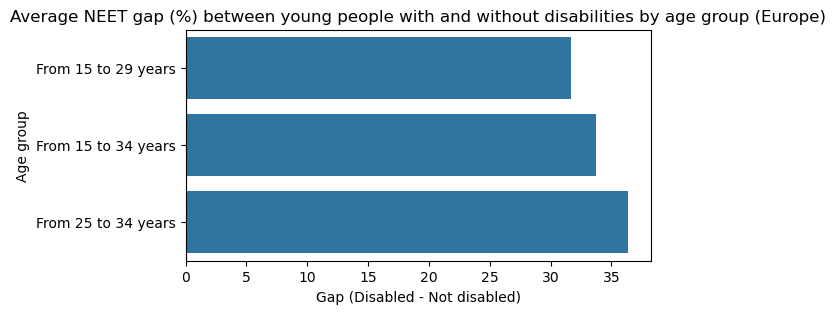

In [ ]:
# By age

df_age = df_edu_young_clean.copy()
df_age["Disability_status"] = df_age["lev_limit"].replace({
    "Severe": "Disabled",
    "Some": "Disabled",
    "Some or severe": "Disabled",
    "None": "Not disabled"
})

df_age = df_age[df_age["Disability_status"].isin(["Disabled", "Not disabled"])]

# Average by country, age and status
df_grouped_age = df_age.groupby(
    ["geo", "age", "Disability_status"]
)["value"].mean().reset_index()

# Pivot Disabled vs Not disabled
df_pivot_age = df_grouped_age.pivot(
    index=["geo", "age"],
    columns="Disability_status",
    values="value"
).reset_index()

# Gap
df_pivot_age["Gap"] = df_pivot_age["Disabled"] - df_pivot_age["Not disabled"]

# Average gap by group age
df_mean_age = df_pivot_age.groupby("age")["Gap"].mean().reset_index()

# Sort by gap (most inclusive = closest to 0 or negative)
df_mean_age = df_mean_age.sort_values("Gap", ascending=True)

# Barplot 
plt.figure(figsize=(6,3))
sns.barplot(
    data=df_mean_age,
    x="Gap", y="age",
    order=df_mean_age["age"]
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Average NEET gap (%) between young people with and without disabilities by age group (Europe)")
plt.xlabel("Gap (Disabled - Not disabled)")
plt.ylabel("Age group")
plt.show()


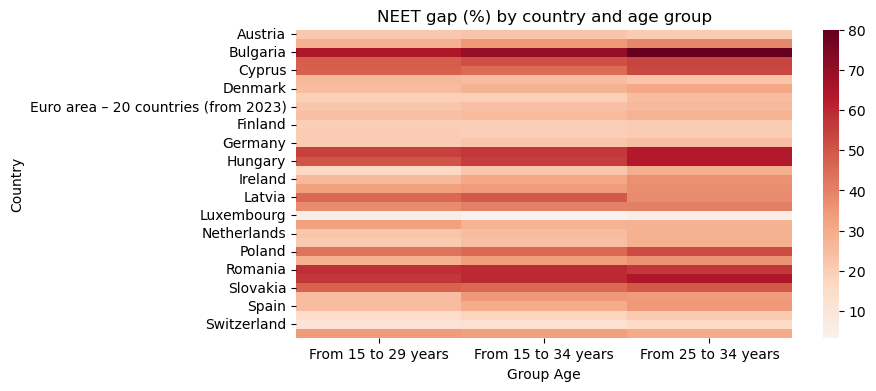

In [ ]:
# Heatmap by country and age
df_heat = df_pivot_age.pivot(index="geo", columns="age", values="Gap")

plt.figure(figsize=(8,4))
sns.heatmap(df_heat, annot=False, cmap="RdBu_r", center=0)
plt.title("NEET gap (%) by country and age group")
plt.xlabel("Group Age")
plt.ylabel("Country")
plt.show()

- Gap (Disabled – Not Disabled) is positive and high, it means that young people with disabilities are much more likely to be Neither in employment nor in education and training → severe social exclusion.

- If the gap is close to 0 → access to education/employment is more inclusive.

- **The most inclusive country for young people neither in employment nor in education and training : Luxembourg** 
- **The less inclusive : Bulgaria**

- The people between **15 and 24 years** are more included.

## Cultural - Sport

1. Persons participating in cultural or sport activities by sex, age, level of disability (activity limitation), activity type and frequency

In [44]:
# Eurostat Data
dataset = "ilc_scp37"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_cultural = pd.DataFrame(combinations, columns=dims)
df_cultural["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_cultural[dim] = df_cultural[dim].map(labels)

df_cultural.head(5)

,freq,acl00,frequenc,lev_limit,sex,age,unit,geo,time,value
0,Annual,"Cultural activities (cinema, live performances...",Not in the last 12 months,Total,Total,From 16 to 24 years,Percentage,Belgium,2022,21.8
1,Annual,"Cultural activities (cinema, live performances...",Not in the last 12 months,Total,Total,From 16 to 24 years,Percentage,Bulgaria,2022,60.1
2,Annual,"Cultural activities (cinema, live performances...",Not in the last 12 months,Total,Total,From 16 to 24 years,Percentage,Czechia,2022,16.8
3,Annual,"Cultural activities (cinema, live performances...",Not in the last 12 months,Total,Total,From 16 to 24 years,Percentage,Denmark,2022,11.8
4,Annual,"Cultural activities (cinema, live performances...",Not in the last 12 months,Total,Total,From 16 to 24 years,Percentage,Germany,2022,NaN


In [45]:
df_cultural["acl00"].unique()

array(['Cultural activities (cinema, live performances or cultural sites)',
       'Cinema', 'Live performances (theatre, concerts, ballet)',
       'Cultural sites (historical monuments, museums, art galleries or archaeological sites)',
       'Sports events'], dtype=object)

2. Persons not participating in cultural or sport activities in the last 12 months by sex, age, level of disability (activity limitation), activity type and reasons

In [46]:
# 1. Eurostat Data
dataset = "ilc_scp38"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# 2. Extraire les dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

# 3. Créer toutes les combinaisons possibles des dimensions
combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# 4. Construire le DataFrame brut
df_not_cultural = pd.DataFrame(combinations, columns=dims)
df_not_cultural["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# 5. Remplacer les codes par les labels lisibles
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_not_cultural[dim] = df_not_cultural[dim].map(labels)

df_not_cultural.head(5)

,freq,acl00,reason,lev_limit,sex,age,unit,geo,time,value
0,Annual,Cinema,Financial reasons,Total,Total,From 16 to 24 years,Percentage,Belgium,2022,13.5
1,Annual,Cinema,Financial reasons,Total,Total,From 16 to 24 years,Percentage,Bulgaria,2022,12.8
2,Annual,Cinema,Financial reasons,Total,Total,From 16 to 24 years,Percentage,Czechia,2022,11.5
3,Annual,Cinema,Financial reasons,Total,Total,From 16 to 24 years,Percentage,Denmark,2022,15.3
4,Annual,Cinema,Financial reasons,Total,Total,From 16 to 24 years,Percentage,Germany,2022,NaN


3. Merge the both

In [47]:
# Merge
df_merged_cultural = pd.merge(
    df_cultural,
    df_not_cultural,
    on=["geo", "time", "lev_limit", "sex", "age", "freq", "unit", "acl00"],
    how="outer" 
)

print(df_merged_cultural.head(2))

     freq   acl00 frequenc lev_limit      sex               age        unit  \
0  Annual  Cinema      NaN      None  Females  16 years or over  Percentage   
1  Annual  Cinema      NaN      None  Females  16 years or over  Percentage   

       geo  time  value_x             reason  value_y  
0  Albania  2022      NaN  Financial reasons     22.4  
1  Albania  2022      NaN        No interest     27.8  


In [48]:
# Rename columns 
df_merged_cultural = df_merged_cultural.rename(columns={
    "value_x": "value_participation",
    "value_y": "value_R_non_part"
})

In [49]:
df_merged_cultural

,freq,acl00,frequenc,lev_limit,sex,age,unit,geo,time,value_participation,reason,value_R_non_part
0,Annual,Cinema,NaN,None,Females,16 years or over,Percentage,Albania,2022,NaN,Financial reasons,22.4
1,Annual,Cinema,NaN,None,Females,16 years or over,Percentage,Albania,2022,NaN,No interest,27.8
2,Annual,Cinema,NaN,None,Females,16 years or over,Percentage,Albania,2022,NaN,None in the neighbourhood,16.6
3,Annual,Cinema,NaN,None,Females,16 years or over,Percentage,Albania,2022,NaN,No time,7.8
4,Annual,Cinema,NaN,None,Females,16 years or over,Percentage,Albania,2022,NaN,Watching/experiencing by other means,19.7
...,...,...,...,...,...,...,...,...,...,...,...,...
822115,Annual,Sports events,At least 4 times,Total,Total,From 75 to 84 years,Percentage,Türkiye,2022,0.2,No interest,92.3
822116,Annual,Sports events,At least 4 times,Total,Total,From 75 to 84 years,Percentage,Türkiye,2022,0.2,None in the neighbourhood,1.2
822117,Annual,Sports events,At least 4 times,Total,Total,From 75 to 84 years,Percentage,Türkiye,2022,0.2,No time,2.3
822118,Annual,Sports events,At least 4 times,Total,Total,From 75 to 84 years,Percentage,Türkiye,2022,0.2,Watching/experiencing by other means,1.3


In [50]:
df_merged_cultural["value_participation"].unique()

array([ nan, 60.8, 32.5, ..., 94.4, 70.3, 69.8])

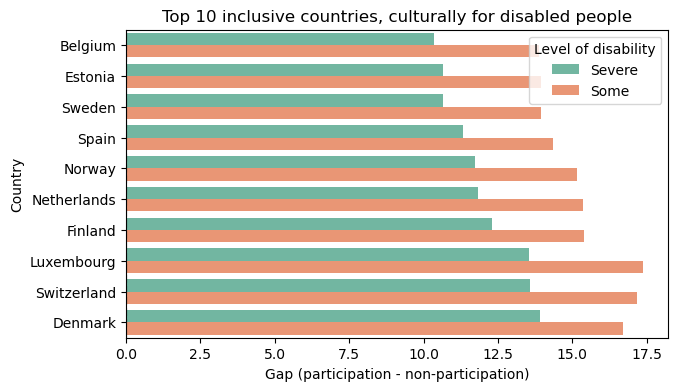

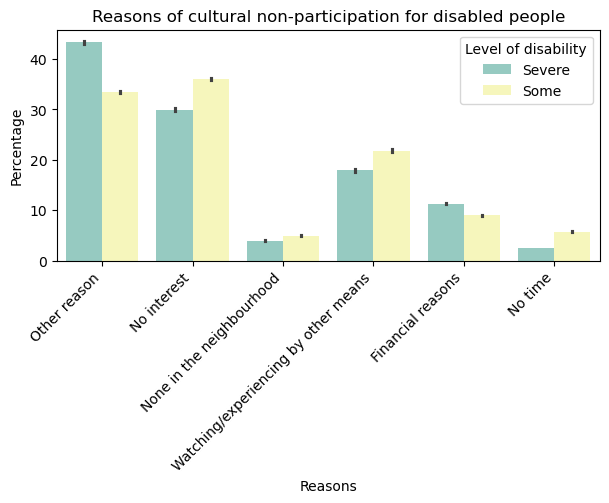

In [53]:
# Visualization

# Cultural Gap 
df_merged_cultural['Gap'] = df_merged_cultural['value_participation'] - df_merged_cultural['value_R_non_part']

# Average Gap by country and level of disability
df_gap_country = df_merged_cultural.groupby(['geo', 'lev_limit'])['Gap'].mean().reset_index()

# Disabled people
df_disabled = df_gap_country[df_gap_country['lev_limit'].isin(['Severe','Some'])]

# Top 10 inclusive countries (highest gap)
top_countries = df_disabled.groupby('geo')['Gap'].mean().sort_values(ascending=False).head(10).index
df_top_countries = df_disabled[df_disabled['geo'].isin(top_countries)]

# Sort by gap
df_top_countries = df_top_countries.sort_values("Gap", ascending=True)

# Barplot
plt.figure(figsize=(7,4))
sns.barplot(
    data=df_top_countries,
    x='Gap',
    y='geo',
    hue='lev_limit',
    palette='Set2'
)
plt.axvline(0, color='black', linestyle='--')
plt.title("Top 10 inclusive countries, culturally for disabled people")
plt.xlabel("Gap (participation - non-participation)")
plt.ylabel("Country")
plt.legend(title="Level of disability")
plt.show()





# Analysis raisons of non-participation
df_reasons = df_merged_cultural[df_merged_cultural['lev_limit'].isin(['Severe','Some'])]

# Sort
df_reasons = df_reasons.sort_values("Gap", ascending=True)

plt.figure(figsize=(7,3))
sns.barplot(
    data=df_reasons,
    x='reason',
    y='value_R_non_part',
    hue='lev_limit',
    palette='Set3'
)
plt.title("Reasons of cultural non-participation for disabled people")
plt.xlabel("Reasons")
plt.ylabel("Percentage")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Level of disability")
plt.show()


In [56]:
# Créer un tableau croisé
tableau_reasons = df_reasons.pivot_table(
    index="reason",
    columns="lev_limit",
    values="value_R_non_part",
    aggfunc="mean"   # au cas où il y a plusieurs lignes par combinaison
).reset_index()

# Afficher le tableau
print(tableau_reasons)

# (Optionnel) tri par ordre du graphique
tableau_reasons = tableau_reasons.set_index("reason").loc[df_reasons["reason"].unique()].reset_index()
print(tableau_reasons)


lev_limit                                reason     Severe       Some
0                             Financial reasons  11.292635   8.989319
1                                   No interest  29.948714  36.013516
2                                       No time   2.509679   5.722840
3                     None in the neighbourhood   3.935835   4.954613
4                                  Other reason  43.337711  33.446075
5          Watching/experiencing by other means  17.896240  21.815914


KeyError: '[nan] not in index'

In [54]:
df_top_countries

,geo,lev_limit,Gap
11,Belgium,Severe,10.349383
41,Estonia,Severe,10.637344
151,Sweden,Severe,10.648067
146,Spain,Severe,11.337192
111,Norway,Severe,11.735191
106,Netherlands,Severe,11.838710
46,Finland,Severe,12.285719
91,Luxembourg,Severe,13.548970
156,Switzerland,Severe,13.558295
12,Belgium,Some,13.865142


Top 10 countries :
- For people with **severe** disabilities, access to culture is inclusive  in **Denmark**.
- For people with **some** disabilities, acces to culture is inclusive in **Luxembourg**.

The gap between Severe and Some, are the same for the countries, the severe one is always less than the Some :

→ **People with Severe disabilities remain excluded**

Reasons of cultural non-participation : 
- For people with **severe** disabilities : the reasons are **various** (other reasons), the second one is because they do not have interest
- For people with **some** disabilities : the main reason is because they **do not have interest**

In [57]:
df_merged_cultural["acl00"].unique()

array(['Cinema',
       'Cultural sites (historical monuments, museums, art galleries or archaeological sites)',
       'Live performances (theatre, concerts, ballet)', 'Sports events',
       'Cultural activities (cinema, live performances or cultural sites)'],
      dtype=object)

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20012/1715364425.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


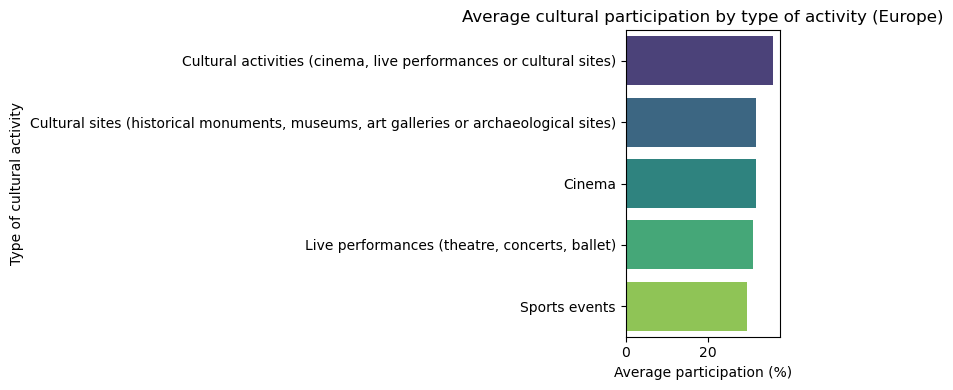

                                               acl00  value_participation
1  Cultural activities (cinema, live performances...            35.721152
2  Cultural sites (historical monuments, museums,...            31.688480
0                                             Cinema            31.561797
3      Live performances (theatre, concerts, ballet)            30.947600
4                                      Sports events            29.425564


In [59]:
# Average of participation by activiy
df_act = (
    df_merged_cultural.groupby("acl00")["value_participation"]
    .mean()
    .reset_index()
)

# Sort
df_act = df_act.sort_values("value_participation", ascending=False)

# Barplot
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_act,
    x="value_participation",
    y="acl00",
    palette="viridis"
)
plt.title("Average cultural participation by type of activity (Europe)")
plt.xlabel("Average participation (%)")
plt.ylabel("Type of cultural activity")
plt.tight_layout()
plt.show()


# Créer le tableau
df_act = (
    df_merged_cultural.groupby("acl00")["value_participation"]
    .mean()
    .reset_index()
    .sort_values("value_participation", ascending=False)
)

# Afficher le tableau
print(df_act)


For all the people who participate in cultural life, the one that comes back the most is globally **all the cultural activities like cinema, live performances or cultural sites**

## Feeling left out from society

Persons feeling left out from society by sex, age and level of disability (activity limitation)

In [3]:
# Eurostat Data
dataset = "ilc_pw12"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_out = pd.DataFrame(combinations, columns=dims)
df_out["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_out[dim] = df_out[dim].map(labels)

df_out

,freq,lev_limit,age,sex,unit,geo,time,value
0,Annual,Total,From 16 to 24 years,Total,Percentage,European Union - 27 countries (from 2020),2022,6.5
1,Annual,Total,From 16 to 24 years,Total,Percentage,Euro area – 20 countries (from 2023),2022,7.2
2,Annual,Total,From 16 to 24 years,Total,Percentage,Belgium,2022,3.3
3,Annual,Total,From 16 to 24 years,Total,Percentage,Bulgaria,2022,3.4
4,Annual,Total,From 16 to 24 years,Total,Percentage,Czechia,2022,3.5
...,...,...,...,...,...,...,...,...
3565,Annual,None,75 years or over,Females,Percentage,Norway,2022,6.9
3566,Annual,None,75 years or over,Females,Percentage,Switzerland,2022,5.8
3567,Annual,None,75 years or over,Females,Percentage,Montenegro,2022,9.7
3568,Annual,None,75 years or over,Females,Percentage,Serbia,2022,18.6


In [4]:
df_out["lev_limit"].unique()

array(['Total', 'Some', 'Severe', 'Some or severe', 'None'], dtype=object)

In [5]:
to_remove = [
    "European Union - 27 countries (from 2020)", 
    "Euro area – 20 countries (from 2023)"
]

df_out = df_out[~df_out["geo"].isin(to_remove)]

# Age
#to_remove_age_out = [
    #'From 15 to 29 years',
    #'From 18 to 24 years',
    #'From 18 to 29 years'
#]
#df_out = df_out[~df_out["age"].isin(to_remove_age_out)]

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20721/3252010885.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_age_left_out, x="value", y="age", palette="viridis")


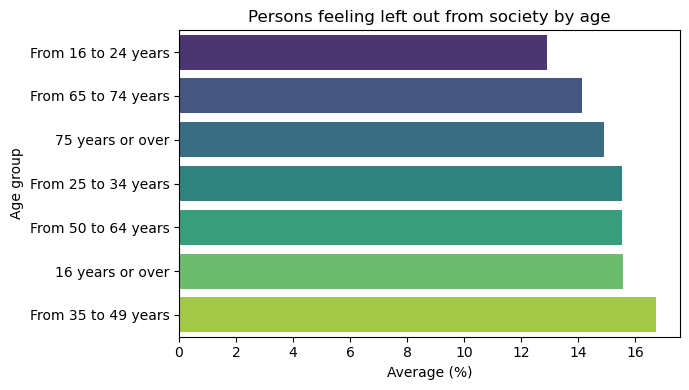

,age,value
2,From 16 to 24 years,12.913495
6,From 65 to 74 years,14.147198
1,75 years or over,14.898922
3,From 25 to 34 years,15.545531
5,From 50 to 64 years,15.556774
0,16 years or over,15.586237
4,From 35 to 49 years,16.743080


In [6]:
# Visualization 

# Repartition by age (Europe = average of all countries)
df_age_left_out = df_out.groupby("age")["value"].mean().reset_index()

# Sort
df_age_left_out = df_age_left_out.sort_values("value", ascending=True)

# Barplot
plt.figure(figsize=(7,4))
sns.barplot(data=df_age_left_out, x="value", y="age", palette="viridis")
plt.title("Persons feeling left out from society by age")
plt.xlabel("Average (%)")
plt.ylabel("Age group")
plt.tight_layout()
plt.show()


df_age_left_out.sort_values("value", ascending=True)

The people who feel most left out from society are those aged between **35 and 49 years**

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20012/1513999880.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_country_out.head(10), x="value", y="geo", palette="magma")


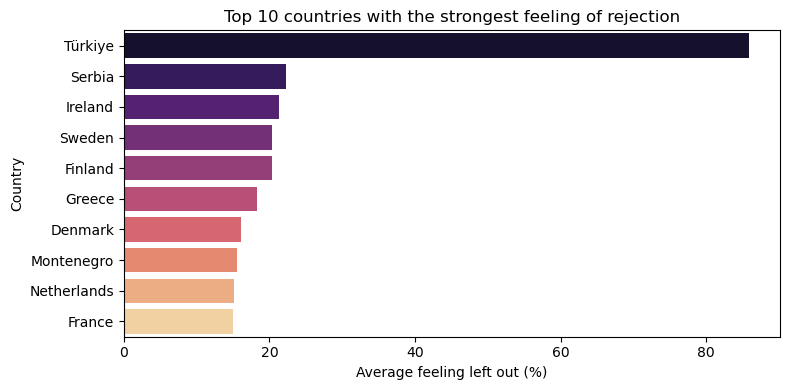

,geo,value
31,Türkiye,85.844762
25,Serbia,22.309091


In [70]:
# Repartition by countries
df_country_out = df_out.groupby("geo")["value"].mean().reset_index()

# Sort = most affected countries at the top
df_country_out = df_country_out.sort_values("value", ascending=False)

# Barplot 
plt.figure(figsize=(8,4))
sns.barplot(data=df_country_out.head(10), x="value", y="geo", palette="magma")
plt.title("Top 10 countries with the strongest feeling of rejection")
plt.xlabel("Average feeling left out (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


df_country_out.head(2)

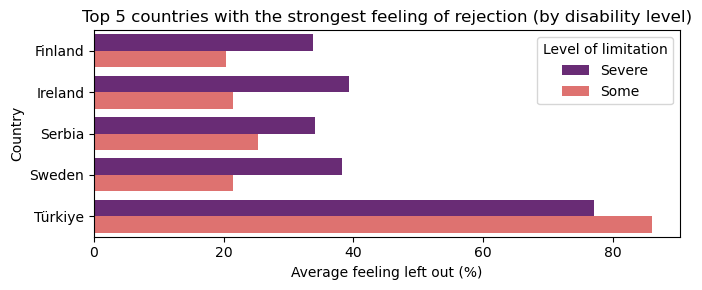

lev_limit      geo     Severe       Some
0          Finland  33.750000  20.361905
1          Ireland  39.315385  21.426667
2           Serbia  34.076923  25.226667
3           Sweden  38.233333  21.500000
4          Türkiye  77.095238  86.104762


In [76]:
# Repartition by countries & lev_limit
df_country_out = (
    df_out[df_out["lev_limit"].isin(["Some", "Severe"])]
    .groupby(["geo", "lev_limit"])["value"]
    .mean()
    .reset_index()
)

# Calculer la moyenne générale par pays pour déterminer le top 10
top5_countries = (
    df_country_out.groupby("geo")["value"]
    .mean()
    .nlargest(5)
    .index
)

# Filtrer uniquement ces 10 pays
df_country_out = df_country_out[df_country_out["geo"].isin(top5_countries)]

# Barplot
plt.figure(figsize=(7,3))
sns.barplot(
    data=df_country_out,
    x="value",
    y="geo",
    hue="lev_limit",
    palette="magma"
)
plt.title("Top 5 countries with the strongest feeling of rejection (by disability level)")
plt.xlabel("Average feeling left out (%)")
plt.ylabel("Country")
plt.legend(title="Level of limitation")
plt.tight_layout()
plt.show()

tableau_out = df_country_out.pivot_table(
    index="geo",
    columns="lev_limit",
    values="value",
    aggfunc="mean"
).reset_index()

# Afficher le tableau
print(tableau_out)


In [7]:
# Repartition by countries & lev_limit
df_country_out = (
    df_out[df_out["lev_limit"].isin(["Some", "Severe"])]
    .groupby(["geo", "lev_limit"])["value"]
    .mean()
    .reset_index()
)

# Calculer la moyenne générale par pays pour déterminer les 5 plus faibles
bottom5_countries = (
    df_country_out.groupby("geo")["value"]
    .mean()
    .nsmallest(5)
    .index
)

# Filtrer uniquement ces 5 pays
df_country_out_bottom5 = df_country_out[df_country_out["geo"].isin(bottom5_countries)]

# Tableau
tableau_bottom5 = df_country_out_bottom5.pivot_table(
    index="geo",
    columns="lev_limit",
    values="value",
    aggfunc="mean"
).reset_index()

# Réordonner comme dans le classement
tableau_bottom5 = tableau_bottom5.set_index("geo").loc[bottom5_countries].reset_index()

print(tableau_bottom5)


lev_limit          geo     Severe      Some
0               Poland  11.240000  4.084211
1             Portugal  10.813333  6.135000
2              Czechia  14.086667  5.378947
3              Austria  14.343750  7.461905
4          Switzerland  13.082353  8.938095


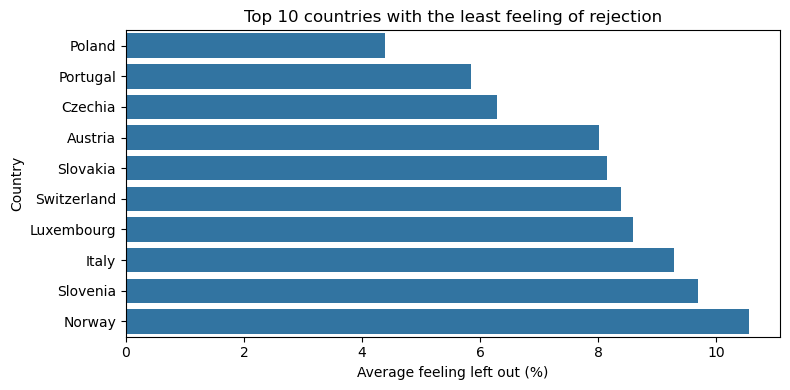

In [ ]:
# Less affected countries at the top
# Countries with the least feeling of left out
df_country_out = df_country_out.sort_values("value", ascending=True)

# Barplot 
plt.figure(figsize=(8,4))
sns.barplot(data=df_country_out.head(10), x="value", y="geo")
plt.title("Top 10 countries with the least feeling of rejection")
plt.xlabel("Average feeling left out (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

**- Turkiye = 85% of disabled people feel left out**

**- Poland = 4%** 


- This may reflect greater social stigma.
- Fewer active inclusion policies (employment, education, culture, sports).
- Infrastructure is less adequate (accessibility, inclusive education, sheltered employment).
- As Turkey is a candidate for EU membership, its social systems are sometimes less harmonized than those in Western/Northern Europe.

- **Strong contrast → inclusion depends largely on public policies and social culture.**

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12591/1798414840.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison, x="value", y="geo", palette="coolwarm")


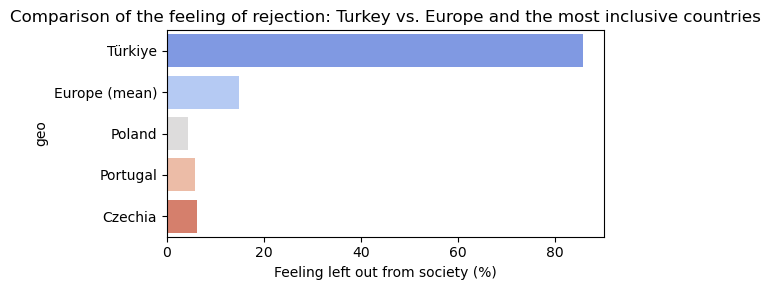

             geo      value
0        Türkiye  85.844762
1  Europe (mean)  14.967310
2         Poland   4.382105
3       Portugal   5.842268
4        Czechia   6.281250


In [ ]:
# Europe Average
europe_mean = df_country_out["value"].mean()

# Türkiye
turkiye_value = df_country_out[df_country_out["geo"] == "Türkiye"]["value"].values[0]

# Top 3 countries most inclusive
top3_inclusive = df_country_out.nsmallest(3, "value")

# Comparative DataFrame 
comparison = pd.DataFrame({
    "geo": ["Türkiye", "Europe (mean)"] + top3_inclusive["geo"].tolist(),
    "value": [turkiye_value, europe_mean] + top3_inclusive["value"].tolist()
})

# Barplot
plt.figure(figsize=(6,3))
sns.barplot(data=comparison, x="value", y="geo", palette="coolwarm")
plt.title("Comparison of the feeling of rejection: Turkey vs. Europe and the most inclusive countries")
plt.xlabel("Feeling left out from society (%)")
plt.tight_layout()
plt.show()

print(comparison)

**→ The feeling of rejection is 6 times higher in Türkiye than the average in the EU.**

## Overall Social Support 

Overall perceived social support by level of disability (activity limitation), sex and age

In [57]:
# Eurostat Data
dataset = "hlth_ehis_ss1d"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_support = pd.DataFrame(combinations, columns=dims)
df_support["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_support[dim] = df_support[dim].map(labels)

df_support

,freq,unit,lev_perc,sex,age,lev_limit,geo,time,value
0,Annual,Percentage,Strong,Total,Total,Total,European Union - 27 countries (from 2020),2014,NaN
1,Annual,Percentage,Strong,Total,Total,Total,European Union - 27 countries (from 2020),2019,37.8
2,Annual,Percentage,Strong,Total,Total,Total,European Union - 28 countries (2013-2020),2014,NaN
3,Annual,Percentage,Strong,Total,Total,Total,European Union - 28 countries (2013-2020),2019,NaN
4,Annual,Percentage,Strong,Total,Total,Total,Belgium,2014,NaN
...,...,...,...,...,...,...,...,...,...
42835,Annual,Percentage,Poor,Females,75 years or over,None,United Kingdom,2019,NaN
42836,Annual,Percentage,Poor,Females,75 years or over,None,Serbia,2014,NaN
42837,Annual,Percentage,Poor,Females,75 years or over,None,Serbia,2019,15.3
42838,Annual,Percentage,Poor,Females,75 years or over,None,Türkiye,2014,23.2


In [58]:
# Country
to_remove_geo = [
    "European Union - 27 countries (from 2020)", 
    "European Union - 28 countries (2013-2020)"
]

df_support = df_support[~df_support["geo"].isin(to_remove_geo)]

# Sex
to_remove_sex = [
    "Total"
]

df_support = df_support[~df_support["sex"].isin(to_remove_sex)]

In [59]:
df_support["lev_limit"].unique()

array(['Total', 'Moderate', 'Severe', 'Some or severe', 'None'],
      dtype=object)

<Figure size 1000x600 with 0 Axes>

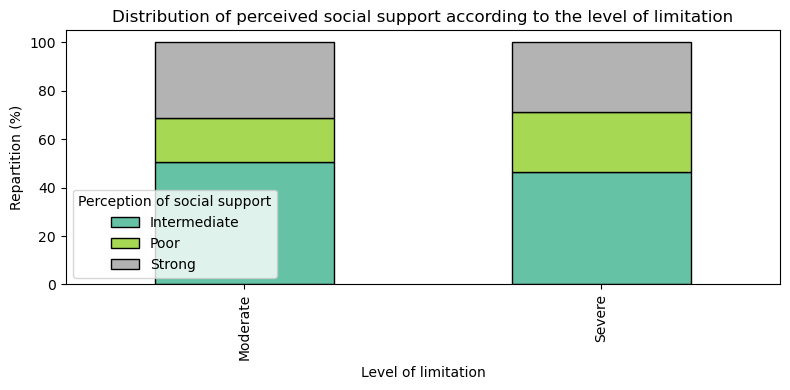

In [ ]:
# Filter
df_disabled_soc = df_support[df_support["lev_limit"].isin(['Severe','Moderate'])]

df_perc = df_disabled_soc.groupby(["lev_limit", "lev_perc"])["value"].mean().reset_index()

# Barplot stacked
plt.figure(figsize=(10,6))
df_pivot = df_perc.pivot(index="lev_limit", columns="lev_perc", values="value")

df_pivot_norm = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

df_pivot_norm.plot(
    kind="bar", stacked=True, figsize=(8,4), colormap="Set2", edgecolor="black"
)

plt.title("Distribution of perceived social support according to the level of limitation")
plt.ylabel("Repartition (%)")
plt.xlabel("Level of limitation")
plt.legend(title="Perception of social support")
plt.tight_layout()
plt.show()


In [ ]:
# Gap
gaps_soc = (df_pivot_norm.loc["Severe"] - df_pivot_norm.loc["Moderate"]).round(2)
print("Gap (Severe - Moderate) in point % :\n")
print(gaps_soc)

Gap (Severe - Moderate) in point % :

lev_perc
Intermediate   -4.22
Poor            6.81
Strong         -2.59
dtype: float64


- People with severe limitations perceive 4 percentage points less “intermediate” social support than those with moderate limitations

- They are nearly 7 percentage points more likely to feel low social support. 

→ This is the strongest signal: **the transition from “moderate” to “severe” significantly increases the risk of isolation.**

- They are also less numerous (≈ –2.6 points) to feel strong support.

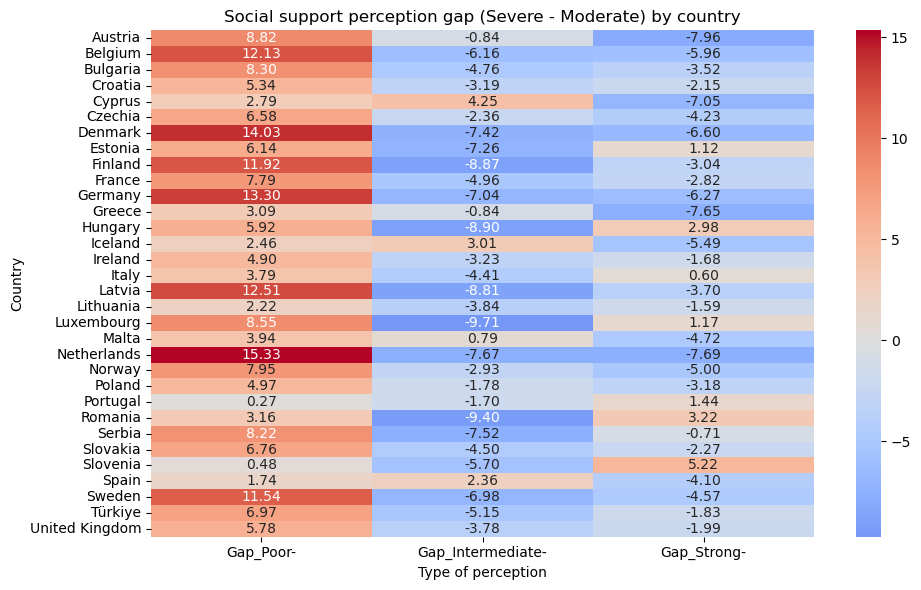

In [ ]:

df_country_soc = df_disabled_soc.groupby(["geo", "lev_perc", "lev_limit"])["value"].mean().reset_index()

df_pivot = df_country_soc.pivot_table(
    index="geo",
    columns=["lev_limit", "lev_perc"],
    values="value"
)

# Calcul de l’écart Severe – Some
df_pivot["Gap_Poor"] = df_pivot[("Severe","Poor")] - df_pivot[("Moderate","Poor")]
df_pivot["Gap_Intermediate"] = df_pivot[("Severe","Intermediate")] - df_pivot[("Moderate","Intermediate")]
df_pivot["Gap_Strong"] = df_pivot[("Severe","Strong")] - df_pivot[("Moderate","Strong")]

# Sélectionner uniquement les gaps pour visualisation
df_gap = df_pivot[["Gap_Poor", "Gap_Intermediate", "Gap_Strong"]].reset_index()

plt.figure(figsize=(10,6))
sns.heatmap(
    df_gap.set_index("geo"),
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Social support perception gap (Severe - Moderate) by country")
plt.xlabel("Type of perception")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

- Positive Gap_Poor → Severe people feel more weak support than Some.

- Negative Gap_Strong → they feel less strong support.

- Compare countries:

Some countries may have very small gaps → more inclusive social policies, better support for all.

Other countries have large gaps → people with severe disabilities are much more socially isolated.

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12591/3959363506.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_inclusifs, x="Gap_Poor", y="geo", palette="Greens_r")


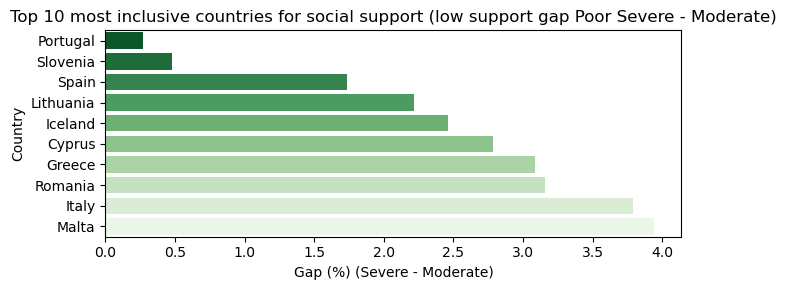

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12591/3959363506.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_exclusifs, x="Gap_Poor", y="geo", palette="Reds_r")


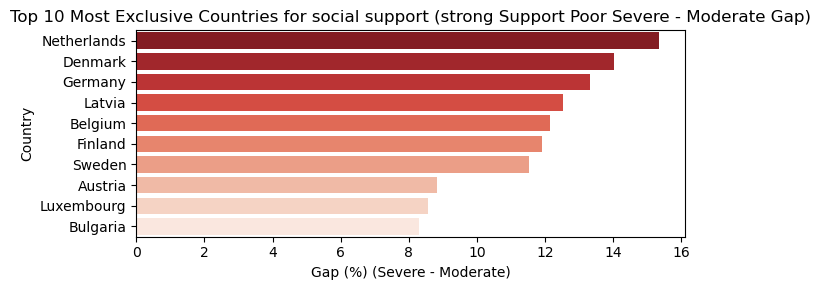

In [ ]:
# Pivot calculate Gap
df_pivot = df_country_soc.pivot_table(
    index="geo",
    columns=["lev_limit", "lev_perc"],
    values="value"
)

# Gap Severe - Moderate
df_pivot["Gap_Poor"] = df_pivot[("Severe","Poor")] - df_pivot[("Moderate","Poor")]

# Sort Top 10 inclusive and exclusive
top_inclusifs = df_pivot.nsmallest(10, "Gap_Poor").reset_index()  # Gap faible ou négatif → inclusif
top_exclusifs = df_pivot.nlargest(10, "Gap_Poor").reset_index()   # Gap fort → excluant

# Barplot inclusive
plt.figure(figsize=(7,3))
sns.barplot(data=top_inclusifs, x="Gap_Poor", y="geo", palette="Greens_r")
plt.title("Top 10 most inclusive countries for social support (low support gap Poor Severe - Moderate)")
plt.xlabel("Gap (%) (Severe - Moderate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Barplot exclusive
plt.figure(figsize=(7,3))
sns.barplot(data=top_exclusifs, x="Gap_Poor", y="geo", palette="Reds_r")
plt.title("Top 10 Most Exclusive Countries for social support (strong Support Poor Severe - Moderate Gap)")
plt.xlabel("Gap (%) (Severe - Moderate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


- Inclusive countries (green bars, low gap):

Portugal : little difference between Severe and Some → people with severe limitations receive almost the same support as those with moderate limitations.

- Exclusive countries (red bars, high gap):

Netherlands : large difference → people with Severe limitations are significantly more isolated and feel less support.


Top 10 countries for support 'Strong' - Severe:


,geo,lev_limit,value
57,Spain,Severe,54.172500
9,Cyprus,Severe,53.131429
27,Iceland,Severe,49.306667
63,United Kingdom,Severe,44.134783
7,Croatia,Severe,42.750000



Top 10 countries for support 'Strong' - Moderate:


,geo,lev_limit,value
8,Cyprus,Moderate,60.183333
56,Spain,Moderate,58.275000
26,Iceland,Moderate,54.795745
0,Austria,Moderate,49.155769
62,United Kingdom,Moderate,46.121429


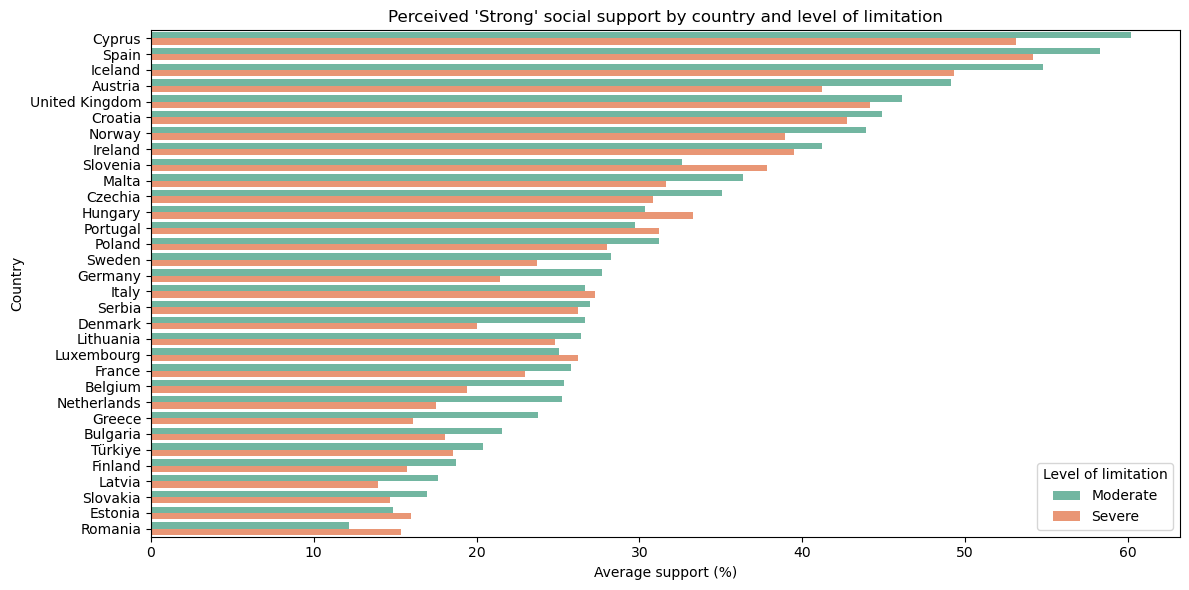

In [ ]:
# Filter "Strong"
levels = ["Severe", "Moderate"]
df_strong = df_support[
    (df_support["lev_limit"].isin(levels)) &
    (df_support["lev_perc"] == "Strong")
]

# Average "Poor" by country and level of limitation
df_country_strong = df_strong.groupby(["geo", "lev_limit"])["value"].mean().reset_index()

# Sort descending to see best countries
df_country_strong_sorted = df_country_strong.sort_values("value", ascending=False)

# Top 10 for each level of limitation
for level in levels:
    print(f"\nTop 10 countries for support 'Strong' - {level}:")
    display(df_country_strong_sorted[df_country_strong_sorted["lev_limit"] == level].head(5))

# 5️⃣ Visualisation comparative
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_country_strong_sorted,
    x="value",
    y="geo",
    hue="lev_limit",
    palette="Set2"
)
plt.title("Perceived 'Strong' social support by country and level of limitation")
plt.xlabel("Average support (%)")
plt.ylabel("Country")
plt.legend(title="Level of limitation")
plt.tight_layout()
plt.show()

**- Cyprus** : The country where people with **moderate disabilities** perceived the most **strong social support.**

**- Spain** : The country where people with **severe disabilities** perceived the most **strong social support.**


Top 10 countries for support 'Poor' - Severe:


,geo,lev_limit,value
41,Netherlands,Severe,39.474359
13,Denmark,Severe,38.402632
17,Finland,Severe,38.205882
33,Latvia,Severe,37.119444
3,Belgium,Severe,37.005000



Top 10 countries for support 'Poor' - Moderate:


,geo,lev_limit,value
48,Romania,Moderate,30.222500
22,Greece,Moderate,26.661905
52,Slovakia,Moderate,26.616000
16,Finland,Moderate,26.286275
14,Estonia,Moderate,25.676923


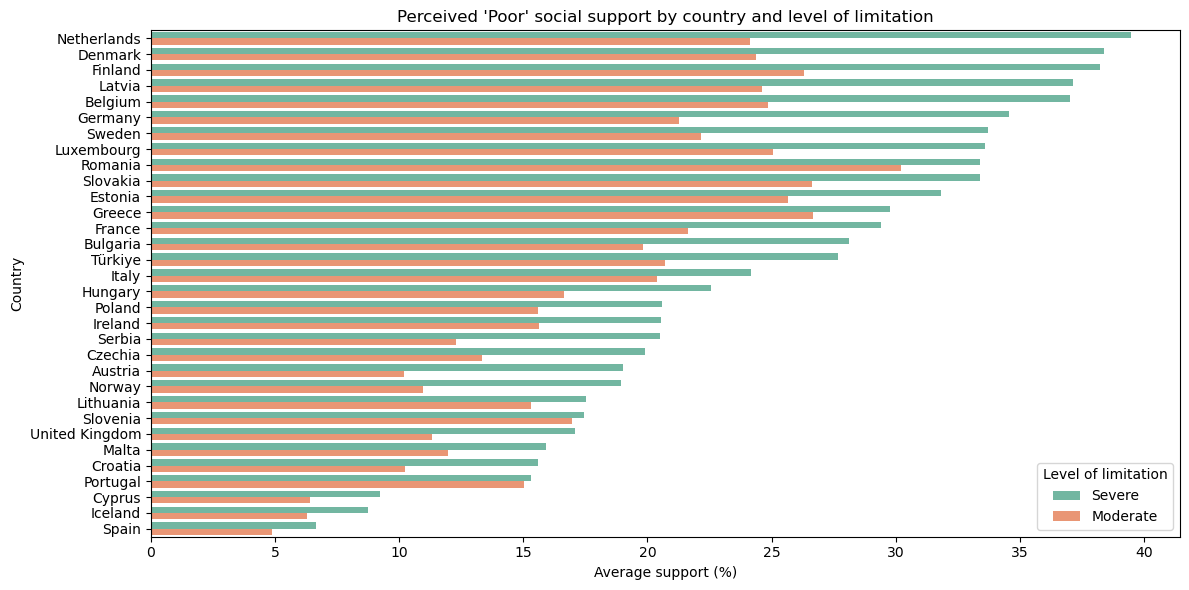

In [ ]:
# Filter "Poor"
levels = ["Severe", "Moderate"]
df_poor = df_support[
    (df_support["lev_limit"].isin(levels)) &
    (df_support["lev_perc"] == "Poor")
]

# Average "Poor" by country and level of limitation
df_country_poor = df_poor.groupby(["geo", "lev_limit"])["value"].mean().reset_index()

# Sort descending to see best countries
df_country_poor_sorted = df_country_poor.sort_values("value", ascending=False)

# Top 10 for each level of limitation
for level in levels:
    print(f"\nTop 10 countries for support 'Poor' - {level}:")
    display(df_country_poor_sorted[df_country_poor_sorted["lev_limit"] == level].head(5))

# 5️⃣ Visualisation comparative
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_country_poor_sorted,
    x="value",
    y="geo",
    hue="lev_limit",
    palette="Set2"
)
plt.title("Perceived 'Poor' social support by country and level of limitation")
plt.xlabel("Average support (%)")
plt.ylabel("Country")
plt.legend(title="Level of limitation")
plt.tight_layout()
plt.show()

**- Romania** : The country where people with **moderate disabilities** perceived the most **poor social support.**

**- Netherland** : The country where people with **severe disabilities** perceived the most **poor social support.**

## Poverty / Social exclusion 

Persons at risk of poverty or social exclusion by level of disability (activity limitation), sex and age

In [8]:
# 1. Eurostat Data
dataset = "hlth_dpe010"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_poverty = pd.DataFrame(combinations, columns=dims)
df_poverty["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_poverty[dim] = df_poverty[dim].map(labels)

df_poverty

,freq,unit,lev_limit,age,sex,geo,time,value
0,Annual,Percentage,Total,From 16 to 24 years,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2014,NaN
1,Annual,Percentage,Total,From 16 to 24 years,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2015,29.7
2,Annual,Percentage,Total,From 16 to 24 years,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2016,29.5
3,Annual,Percentage,Total,From 16 to 24 years,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2017,27.9
4,Annual,Percentage,Total,From 16 to 24 years,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2018,26.6
...,...,...,...,...,...,...,...,...
66820,Annual,Percentage,None,65 years or over,Females,Kosovo*,2020,NaN
66821,Annual,Percentage,None,65 years or over,Females,Kosovo*,2021,NaN
66822,Annual,Percentage,None,65 years or over,Females,Kosovo*,2022,NaN
66823,Annual,Percentage,None,65 years or over,Females,Kosovo*,2023,NaN


In [9]:
df_poverty["lev_limit"].unique()

array(['Total', 'Some', 'Severe', 'Some or severe', 'None'], dtype=object)

In [10]:
df_poverty["geo"].unique()

array(['European Union (EU6-1958, EU9-1973, EU10-1981, EU12-1986, EU15-1995, EU25-2004, EU27-2007, EU28-2013, EU27-2020)',
       'European Union - 27 countries (from 2020)',
       'European Union - 28 countries (2013-2020)',
       'European Union - 27 countries (2007-2013)',
       'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)',
       'Euro area – 20 countries (from 2023)',
       'Euro area - 19 countries  (2015-2022)',
       'Euro area - 18 countries (2014)', 'Belgium', 'Bulgaria',
       'Czechia', 'Denmark', 'Germany', 'Estonia', 'Ireland', 'Greece',
       'Spain', 'France', 'Croatia', 'Italy', 'Cyprus', 'Latvia',
       'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia',
       'Finland', 'Sweden', 'Iceland', 'Norway', 'Switzerland',
       'United Kingdom', 'Montenegro', 'North Macedonia', 'Albania',
       'Serbia', 'Türkiye'

In [11]:
to_remove_geo_po = [
    "European Union (EU6-1958, EU9-1973, EU10-1981, EU12-1986, EU15-1995, EU25-2004, EU27-2007, EU28-2013, EU27-2020)",
       'European Union - 27 countries (from 2020)',
       'European Union - 28 countries (2013-2020)',
       'European Union - 27 countries (2007-2013)',
       'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)',
       'Euro area – 20 countries (from 2023)',
       'Euro area - 19 countries  (2015-2022)',
       'Euro area - 18 countries (2014)'
]

df_poverty = df_poverty[~df_poverty["geo"].isin(to_remove_geo_po)]

In [12]:
to_remove_sex_po = [
    "Total"
]

df_poverty = df_poverty[~df_poverty["sex"].isin(to_remove_sex_po)]

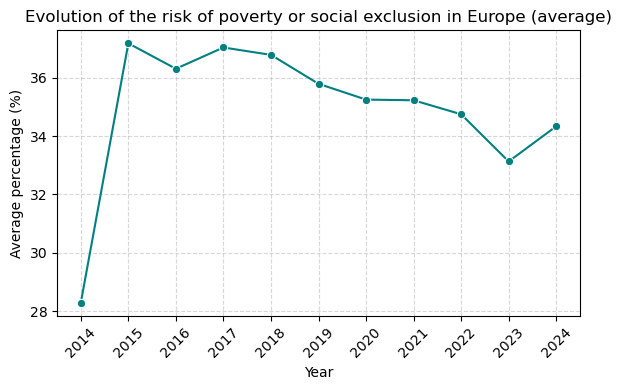

In [13]:
df_poverty_filtered = df_poverty[df_poverty["lev_limit"].isin(['Some', 'Severe', 'Some or severe'])]

# Average risk of poverty per year
df_yearly = df_poverty_filtered.groupby("time")["value"].mean().reset_index()

df_yearly["time"] = df_yearly["time"].astype(int)

# Lineplot
plt.figure(figsize=(6,4))
sns.lineplot(data=df_yearly, x="time", y="value", marker="o", color="teal")
plt.title("Evolution of the risk of poverty or social exclusion in Europe (average)")
plt.xlabel("Year")
plt.ylabel("Average percentage (%)")
plt.xticks(df_yearly["time"], rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
df_yearly

,time,value
0,2014,28.286170
1,2015,37.186172
2,2016,36.312899
3,2017,37.042397
4,2018,36.789544
5,2019,35.797296
6,2020,35.254715
7,2021,35.232178
8,2022,34.752295
9,2023,33.132028


Social trends and the impact of public policies : On average in Europe, **fewer and fewer people are living below the poverty line or in a situation of social exclusion.**

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20721/3481488862.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


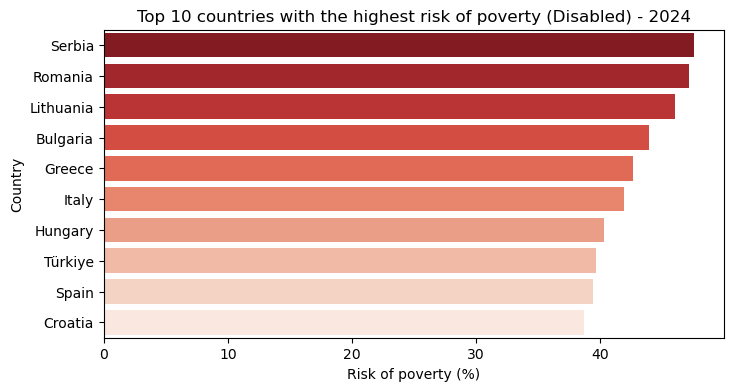

,geo,value
29,Serbia,47.574359
28,Romania,47.179412
19,Lithuania,46.044737
3,Bulgaria,43.913889
12,Greece,42.639474
16,Italy,41.951923
13,Hungary,40.269565
35,Türkiye,39.657407
32,Spain,39.411321
4,Croatia,38.655102


In [15]:
latest_year = df_poverty_filtered["time"].max()
df_latest = df_poverty_filtered[df_poverty_filtered["time"] == latest_year]

# Average risk by country
df_country_risk = df_latest.groupby("geo")["value"].mean().reset_index()

# Sort by descending risk (Top 10 country)
df_top10_risk = df_country_risk.sort_values("value", ascending=False).head(10)

# Plot
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_top10_risk,
    x="value",
    y="geo",
    palette="Reds_r"
)
plt.title(f"Top 10 countries with the highest risk of poverty (Disabled) - {latest_year}")
plt.xlabel("Risk of poverty (%)")
plt.ylabel("Country")
plt.show()


df_top10_risk

**Serbia and Romania** are the countries where there are the highest risk of poverty for people with disabilities.

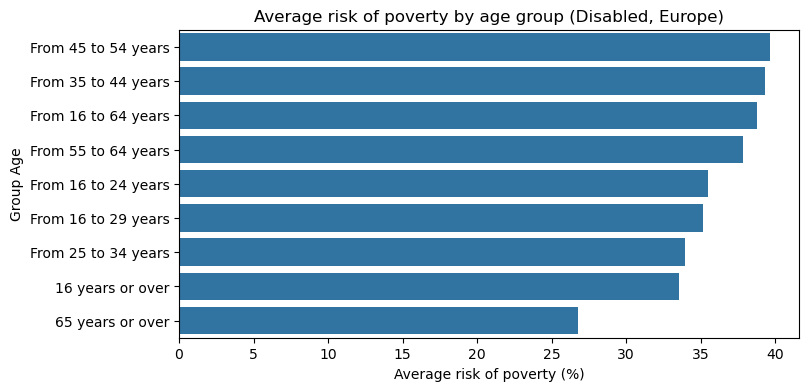

,age,value
7,From 45 to 54 years,39.630409
6,From 35 to 44 years,39.345720
4,From 16 to 64 years,38.759951
8,From 55 to 64 years,37.856225
2,From 16 to 24 years,35.514355
3,From 16 to 29 years,35.159619
5,From 25 to 34 years,33.969728
0,16 years or over,33.537805
1,65 years or over,26.796486


In [ ]:
# Average risk by age
df_age_risk = df_poverty_filtered.groupby("age")["value"].mean().reset_index()

# Sort by secending risk
df_age_risk_sorted = df_age_risk.sort_values("value", ascending=False)

# Plot
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_age_risk_sorted,
    x="value",
    y="age",
)
plt.title("Average risk of poverty by age group (Disabled, Europe)")
plt.xlabel("Average risk of poverty (%)")
plt.ylabel("Group Age")
plt.show()

# Results
display(df_age_risk_sorted)

**Middle-aged (45-54 years)** are most exposed to the risk of poverty.

## Labour Market

Disability employment gap by level of activity limitation and sex (source EU-SILC)

In [16]:
# 1. Eurostat Data
dataset = "hlth_dlm200"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_labourm = pd.DataFrame(combinations, columns=dims)
df_labourm["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_labourm[dim] = df_labourm[dim].map(labels)

df_labourm.head(5)

,freq,unit,lev_limit,sex,geo,time,value
0,Annual,Percentage point,Some,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2010,NaN
1,Annual,Percentage point,Some,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2011,NaN
2,Annual,Percentage point,Some,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2012,NaN
3,Annual,Percentage point,Some,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2013,NaN
4,Annual,Percentage point,Some,Total,"European Union (EU6-1958, EU9-1973, EU10-1981,...",2014,NaN


In [17]:
to_remove_geo_lab = [
    'European Union (EU6-1958, EU9-1973, EU10-1981, EU12-1986, EU15-1995, EU25-2004, EU27-2007, EU28-2013, EU27-2020)',
       'European Union - 27 countries (from 2020)',
       'European Union - 28 countries (2013-2020)',
       'European Union - 27 countries (2007-2013)',
       'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)',
       'Euro area – 20 countries (from 2023)',
       'Euro area - 19 countries  (2015-2022)',
       'Euro area - 18 countries (2014)'
]

df_labourm = df_labourm[~df_labourm["geo"].isin(to_remove_geo_lab)]


# Sex
to_remove_sex_lab = [
    "Total"
]

df_labourm = df_labourm[~df_labourm["sex"].isin(to_remove_sex_lab)]

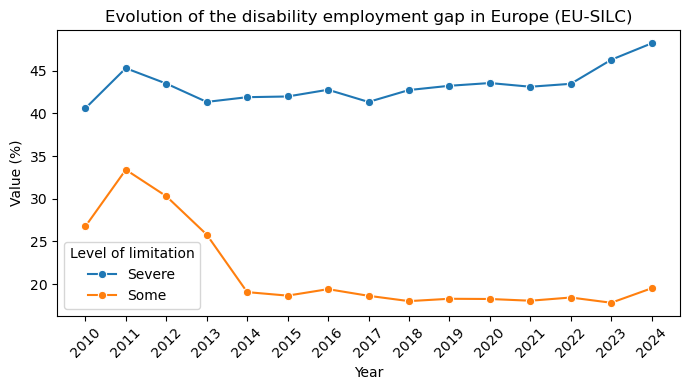

In [19]:
df_labourm_dis = df_labourm[df_labourm["lev_limit"].isin(['Some', 'Severe'])]

# 1. Moyenne par année et niveau de limitation
df_time_lab = df_labourm_dis.groupby(["time", "lev_limit"])["value"].mean().reset_index()

# 2. Visualisation
plt.figure(figsize=(7,4))
sns.lineplot(
    data=df_time_lab,
    x="time",
    y="value",
    hue="lev_limit",
    marker="o"
)
plt.title("Evolution of the disability employment gap in Europe (EU-SILC)")
plt.xlabel("Year")
plt.ylabel("Value (%)")
plt.legend(title="Level of limitation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

→ There is a **huge employment gap** between the people who have severe and some disabilities : **Severe is well above**

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12591/3577556992.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


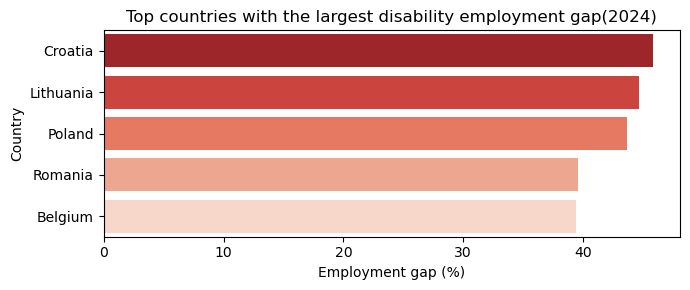

In [ ]:
df_labourm_dis = df_labourm[df_labourm["lev_limit"].isin(['Some', 'Severe'])]

# Last Year
latest_year_lab = df_labourm_dis["time"].max()
df_latest_lab = df_labourm_dis[df_labourm_dis["time"] == latest_year]

# Average by country
df_country_latest = df_latest_lab.groupby("geo")["value"].mean().reset_index()

# Gap descending
df_country_latest_sorted = df_country_latest.sort_values("value", ascending=False)

# Plot
plt.figure(figsize=(7,3))
sns.barplot(
    data=df_country_latest_sorted.head(5),
    x="value",
    y="geo",
    palette="Reds_r"
)
plt.title(f"Top countries with the largest disability employment gap({latest_year})")
plt.xlabel("Employment gap (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

In 2024, **Lithuania** has the largest disability employment gap between the people with some or severe disabilities.

Employment by level of disability (activity limitation) and occupation

In [20]:
# 1. Eurostat Data
dataset = "lfsa_egaidl"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_employment = pd.DataFrame(combinations, columns=dims)
df_employment["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_employment[dim] = df_employment[dim].map(labels)

df_employment.head(5)

,freq,lev_limit,isco08,age,sex,unit,geo,time,value
0,Annual,Total,Total,From 15 to 19 years,Total,Thousand persons,European Union - 27 countries (from 2020),2022,3669.7
1,Annual,Total,Total,From 15 to 19 years,Total,Thousand persons,European Union - 27 countries (from 2020),2024,3822.7
2,Annual,Total,Total,From 15 to 19 years,Total,Thousand persons,Euro area – 20 countries (from 2023),2022,3186.2
3,Annual,Total,Total,From 15 to 19 years,Total,Thousand persons,Euro area – 20 countries (from 2023),2024,3302.7
4,Annual,Total,Total,From 15 to 19 years,Total,Thousand persons,Belgium,2022,62.4


In [21]:
df_employment["lev_limit"].unique()

array(['Total', 'Some', 'Severe', 'Some or severe', 'None', 'No response'],
      dtype=object)

In [22]:
df_employment["geo"].unique()

array(['European Union - 27 countries (from 2020)',
       'Euro area – 20 countries (from 2023)', 'Belgium', 'Bulgaria',
       'Czechia', 'Denmark', 'Germany', 'Estonia', 'Ireland', 'Greece',
       'Spain', 'France', 'Croatia', 'Italy', 'Cyprus', 'Latvia',
       'Lithuania', 'Luxembourg', 'Hungary', 'Malta', 'Netherlands',
       'Austria', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Slovakia',
       'Finland', 'Sweden', 'Iceland', 'Norway', 'Switzerland',
       'Bosnia and Herzegovina', 'Serbia', 'Türkiye'], dtype=object)

In [23]:
to_remove_geo_emp = [
    'European Union - 27 countries (from 2020)',
    'Euro area – 20 countries (from 2023)'
]

df_employment = df_employment[~df_employment["geo"].isin(to_remove_geo_emp)]


# Sex
to_remove_sex_emp = [
    "Total"
]

df_employment = df_employment[~df_employment["sex"].isin(to_remove_sex_emp)]


# ISCO08
to_remove_isco_emp = [
    "Total"
]

df_employment = df_employment[~df_employment["isco08"].isin(to_remove_isco_emp)]

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20721/2255028808.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


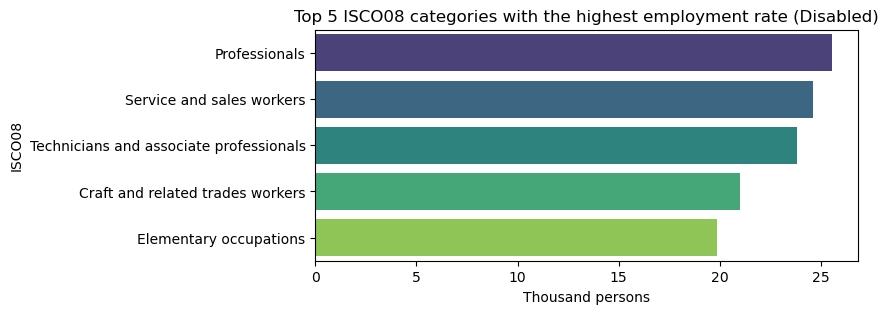

,isco08,value
7,Professionals,25.537004
8,Service and sales workers,24.594748
10,Technicians and associate professionals,23.793172
2,Craft and related trades workers,20.979719
3,Elementary occupations,19.866943


In [24]:
df_emp_filt = df_employment[df_employment["lev_limit"].isin(["Some", "Severe"])]

# 2️⃣ Moyenne du taux d'emploi par catégorie ISCO08
df_isco = df_emp_filt.groupby("isco08")["value"].mean().reset_index()

# 3️⃣ Trier pour obtenir le Top 5
df_isco_top5 = df_isco.sort_values("value", ascending=False).head(5)

# 4️⃣ Visualisation
plt.figure(figsize=(7,3))
sns.barplot(
    data=df_isco_top5,
    x="value",
    y="isco08",
    palette="viridis"
)
plt.title("Top 5 ISCO08 categories with the highest employment rate (Disabled)")
plt.xlabel("Thousand persons")
plt.ylabel("ISCO08")
plt.show()

display(df_isco_top5)

International Standard Classification of Occupations

- Professional : Occupations that require a high level of theoretical and practical training (often a university degree or equivalent). These occupations typically involve managing complex problems, analytical thinking, and the application of specialized knowledge (doctors, academics, teachers, and researchers, psychologists, civil Engineers and Similar Occupations...).

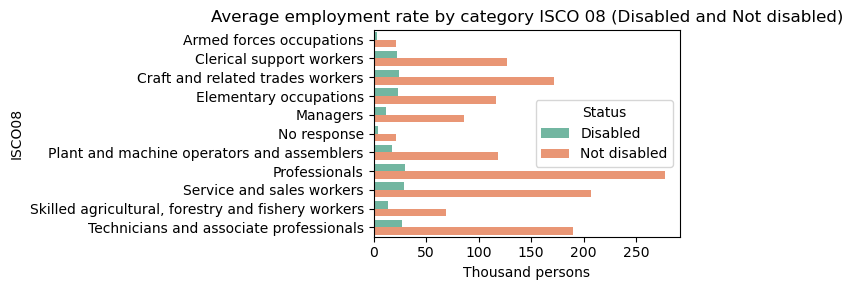

,isco08,Disability_status,value
0,Armed forces occupations,Disabled,3.118667
1,Armed forces occupations,Not disabled,21.713647
2,Clerical support workers,Disabled,22.128094
3,Clerical support workers,Not disabled,127.333012
4,Craft and related trades workers,Disabled,24.154012
5,Craft and related trades workers,Not disabled,171.807790
6,Elementary occupations,Disabled,22.912473
7,Elementary occupations,Not disabled,116.634524
8,Managers,Disabled,11.911639
9,Managers,Not disabled,86.312019


In [73]:
df_clean_status_emplo = df_employment[df_employment["lev_limit"].isin(["Some", "Severe", "Some or severe", "None"])]

# "Disability_status" column
df_status = df_clean_status_emplo.copy()
df_status["Disability_status"] = df_status["lev_limit"].replace({
    "Some": "Disabled",
    "Severe": "Disabled",
    "Some or severe": "Disabled",
    "None": "Not disabled"
})

# Average person by ISCO08 and status
df_grouped = df_status.groupby(["isco08", "Disability_status"])["value"].mean().reset_index()

# Trier pour le Top 5 des catégories avec le plus haut taux d'emploi (pour Disabled)
top5_disabled = df_grouped[df_grouped["Disability_status"] == "Disabled"].sort_values("value", ascending=False)#head(5)

# Filter DataFrame for Top 5 
df_top5_compare = df_grouped[df_grouped["isco08"].isin(top5_disabled["isco08"])]

# Plot
plt.figure(figsize=(7,3))
sns.barplot(
    data=df_top5_compare,
    x="value",
    y="isco08",
    hue="Disability_status",
    palette="Set2"
)
plt.title("Average employment rate by category ISCO 08 (Disabled and Not disabled)")
plt.xlabel("Thousand persons")
plt.ylabel("ISCO08")
plt.legend(title="Status")
plt.tight_layout()
plt.show()


display(df_top5_compare)


In [74]:
# Count
#counts = df_status["Disability_status"].value_counts().reset_index()
#counts.columns = ["Disability_status", "Count"]

# Percentage
#total = counts["Count"].sum()
#counts["Percentage"] = counts["Count"] / total * 100

#print(counts)


In [75]:
df_employment

,freq,lev_limit,isco08,age,sex,unit,geo,time,value
4484,Annual,Total,Managers,From 15 to 19 years,Males,Thousand persons,Belgium,2022,NaN
4485,Annual,Total,Managers,From 15 to 19 years,Males,Thousand persons,Belgium,2024,NaN
4486,Annual,Total,Managers,From 15 to 19 years,Males,Thousand persons,Bulgaria,2022,NaN
4487,Annual,Total,Managers,From 15 to 19 years,Males,Thousand persons,Bulgaria,2024,NaN
4488,Annual,Total,Managers,From 15 to 19 years,Males,Thousand persons,Czechia,2022,NaN
...,...,...,...,...,...,...,...,...,...
317515,Annual,No response,No response,From 75 to 89 years,Females,Thousand persons,Bosnia and Herzegovina,2024,NaN
317516,Annual,No response,No response,From 75 to 89 years,Females,Thousand persons,Serbia,2022,NaN
317517,Annual,No response,No response,From 75 to 89 years,Females,Thousand persons,Serbia,2024,NaN
317518,Annual,No response,No response,From 75 to 89 years,Females,Thousand persons,Türkiye,2022,NaN


Unemployment rates by level of disability (activity limitation) and educational attainment level

In [25]:
# 1. Eurostat Data
dataset = "lfsa_urgaeddl"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_unemployment = pd.DataFrame(combinations, columns=dims)
df_unemployment["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_unemployment[dim] = df_unemployment[dim].map(labels)

df_unemployment.head(3)

,freq,isced11,lev_limit,age,sex,unit,geo,time,value
0,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,European Union - 27 countries (from 2020),2022,19.4
1,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,European Union - 27 countries (from 2020),2024,21.3
2,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,Euro area – 20 countries (from 2023),2022,18.1


In [26]:
to_remove_geo_unemp = [
    'European Union - 27 countries (from 2020)',
       'Euro area – 20 countries (from 2023)'
]

df_unemployment = df_unemployment[~df_unemployment["geo"].isin(to_remove_geo_unemp)]


# Sex
to_remove_sex_unemp = [
    "Total"
]

df_unemployment = df_unemployment[~df_unemployment["sex"].isin(to_remove_sex_unemp)]


# ISCED11
to_remove_isced_unemp = [
    "All ISCED 2011 levels",
    "No response"
]

df_unemployment = df_unemployment[~df_unemployment["isced11"].isin(to_remove_isced_unemp)]

# Lev limit 
to_remove_levlim_unemp = [
    "Total"
]

df_unemployment = df_unemployment[~df_unemployment["lev_limit"].isin(to_remove_levlim_unemp)]

In [27]:
df_unemployment["geo"].unique()

array(['Belgium', 'Bulgaria', 'Czechia', 'Denmark', 'Germany', 'Estonia',
       'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
       'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
       'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
       'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'Iceland', 'Norway',
       'Switzerland', 'Bosnia and Herzegovina', 'Serbia', 'Türkiye'],
      dtype=object)

In [28]:
df_unemployment.columns

Index(['freq', 'isced11', 'lev_limit', 'age', 'sex', 'unit', 'geo', 'time',
       'value'],
      dtype='object')

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20721/1935454722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edu_unemp["Disability_status"] = df_edu_unemp["lev_limit"].replace({


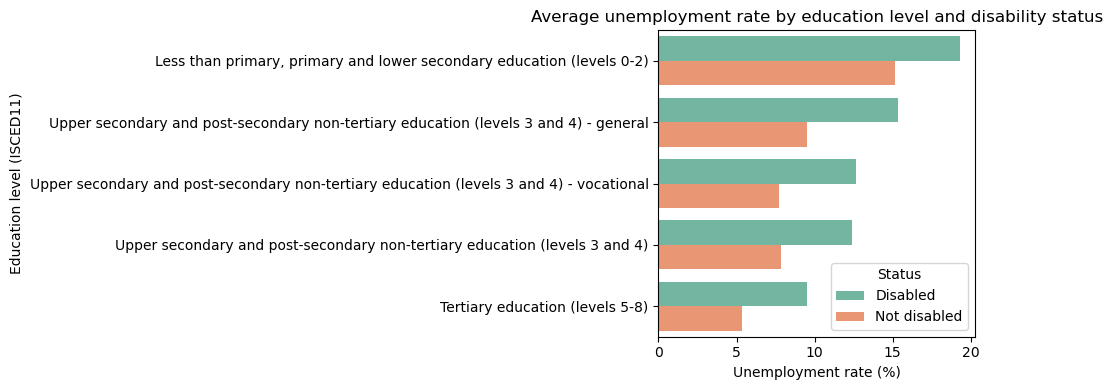

In [29]:
df_edu_unemp = df_unemployment[df_unemployment["lev_limit"].isin(["Some", "Severe", "Some or severe", "None"])]

# Column Disability_status
df_edu_unemp["Disability_status"] = df_edu_unemp["lev_limit"].replace({
    "Severe": "Disabled",
    "Some": "Disabled",
    "Some or severe": "Disabled",
    "None": "Not disabled"
})

# Average unemployment rate by isced11 and status
df_grouped_unemp = df_edu_unemp.groupby(["isced11", "Disability_status"])["value"].mean().reset_index()

# Sort descending to see the most affected education levels
df_grouped_sorted = df_grouped_unemp.sort_values("value", ascending=False)

# Plot
plt.figure(figsize=(10,4))
sns.barplot(
    data=df_grouped_sorted,
    x="value",
    y="isced11",
    hue="Disability_status",
    palette="Set2"
)
plt.title("Average unemployment rate by education level and disability status")
plt.xlabel("Unemployment rate (%)")
plt.ylabel("Education level (ISCED11)")
plt.legend(title="Status")
plt.tight_layout()
plt.show()


/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20721/1686361867.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


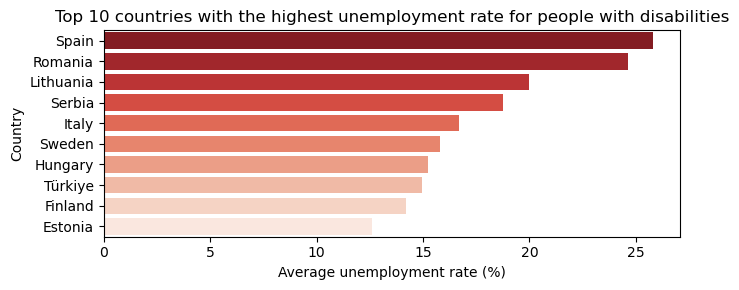

,geo,value
29,Spain,25.786319
25,Romania,24.647059
18,Lithuania,19.964179
26,Serbia,18.767857
16,Italy,16.681626
30,Sweden,15.778451
13,Hungary,15.211628
32,Türkiye,14.964205
9,Finland,14.219894
8,Estonia,12.614035


In [33]:
# Filter Disabled
df_country_unemp = df_unemployment[df_unemployment["lev_limit"].isin(["Some", "Severe", "Some or severe"])]

# Average unemployment rate
df_country_avg = df_country_unemp.groupby("geo")["value"].mean().reset_index()

# Top 10 country with the highest unemployment rate
df_top10_lab_unem = df_country_avg.sort_values("value", ascending=False).head(10)

# Visualization
plt.figure(figsize=(7,3))
sns.barplot(
    data=df_top10_lab_unem,
    x="value",
    y="geo",
    palette="Reds_r"
)
plt.title("Top 10 countries with the highest unemployment rate for people with disabilities")
plt.xlabel("Average unemployment rate (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

df_top10_lab_unem

/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20721/485715926.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


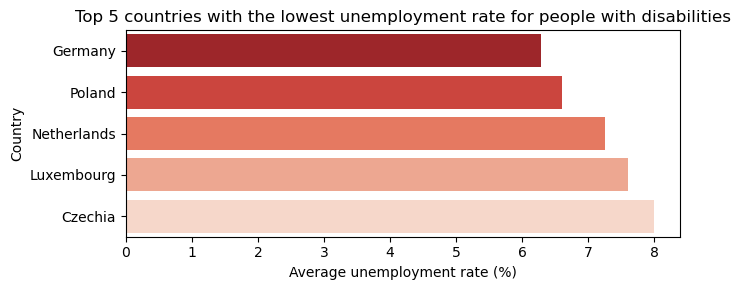

,geo,value
11,Germany,6.278333
23,Poland,6.595082
21,Netherlands,7.256987
19,Luxembourg,7.604762
6,Czechia,7.988018


In [41]:
# Filter Disabled
df_country_unemp = df_unemployment[df_unemployment["lev_limit"].isin(["Some", "Severe", "Some or severe"])]

# Average unemployment rate
df_country_avg = df_country_unemp.groupby("geo")["value"].mean().reset_index()

# Top 10 country with the highest unemployment rate
df_top5_lab_unem_b = df_country_avg.sort_values("value", ascending=True).head(5)

# Visualization
plt.figure(figsize=(7,3))
sns.barplot(
    data=df_top5_lab_unem_b,
    x="value",
    y="geo",
    palette="Reds_r"
)
plt.title("Top 5 countries with the lowest unemployment rate for people with disabilities")
plt.xlabel("Average unemployment rate (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

df_top5_lab_unem_b

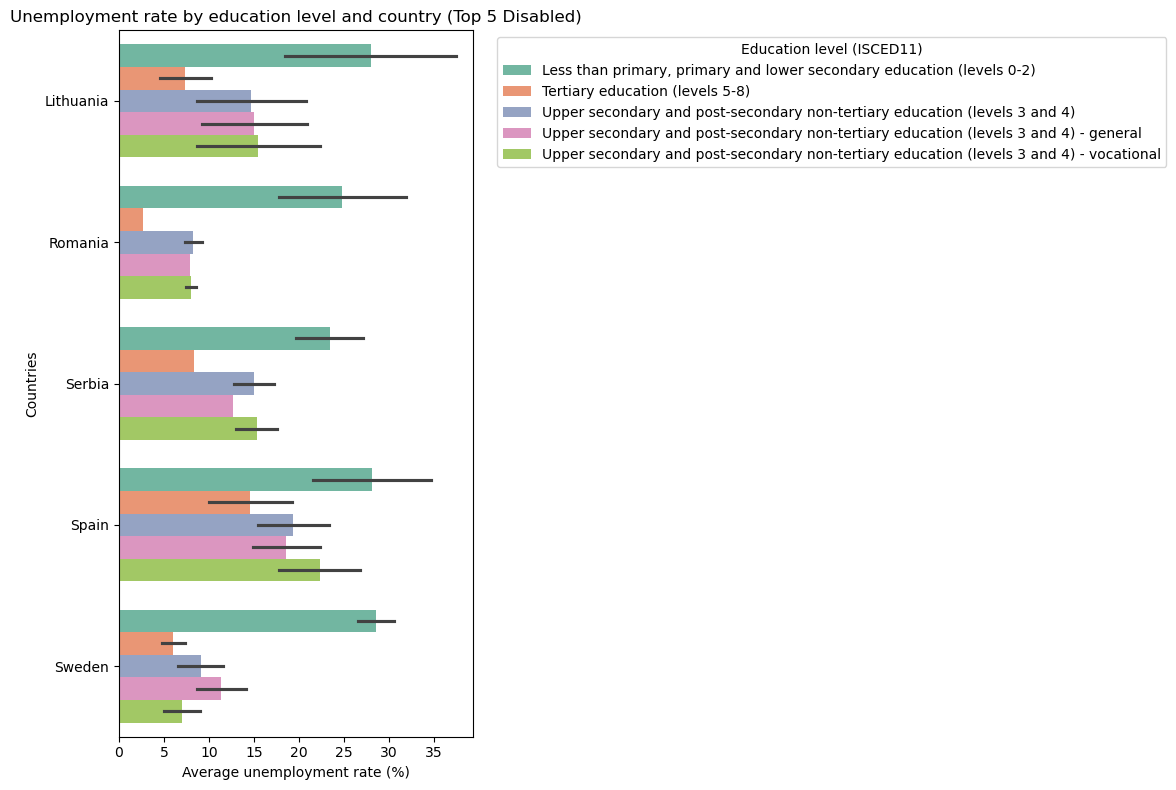

In [ ]:
# Average uneployment rate by country and level of education
df_grouped_unemp = df_edu_unemp.groupby(["geo", "isced11", "Disability_status"])["value"].mean().reset_index()

# Top 5 countries countries most affected for Disabled people
top5_countries = df_grouped_unemp[df_grouped_unemp["Disability_status"]=="Disabled"].sort_values("value", ascending=False).head(5)["geo"]
df_top5_unemp = df_grouped_unemp[df_grouped_unemp["geo"].isin(top5_countries)]

# 5️⃣ Visualisation comparative
plt.figure(figsize=(12,8))
sns.barplot(
    data=df_top5_unemp,
    x="value",
    y="geo",
    hue="isced11",
    palette="Set2"
)
plt.title("Unemployment rate by education level and country (Top 5 Disabled)")
plt.xlabel("Average unemployment rate (%)")
plt.ylabel("Countries")
plt.legend(title="Education level (ISCED11)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- In every country, the higher unemployment rate is for disabled people who have **less than primary and lower secondary education**.

Inactive population by level of disability (activity limitation) and educational attainment level - % of total population

In [ ]:
# 1. Eurostat Data
dataset = "lfsa_ipgaeddl"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# Dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# DataFrame 
df_inactive = pd.DataFrame(combinations, columns=dims)
df_inactive["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# Labels 
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_inactive[dim] = df_inactive[dim].map(labels)

df_inactive


,freq,isced11,lev_limit,age,sex,unit,geo,time,value
0,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,European Union - 27 countries (from 2020),2022,80.3
1,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,European Union - 27 countries (from 2020),2024,79.7
2,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,Euro area – 20 countries (from 2023),2022,78.6
3,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,Euro area – 20 countries (from 2023),2024,78.0
4,Annual,All ISCED 2011 levels,Total,From 15 to 19 years,Total,Percentage,Belgium,2022,88.2
...,...,...,...,...,...,...,...,...,...
185215,Annual,No response,No response,From 75 to 89 years,Females,Percentage,Bosnia and Herzegovina,2024,NaN
185216,Annual,No response,No response,From 75 to 89 years,Females,Percentage,Serbia,2022,NaN
185217,Annual,No response,No response,From 75 to 89 years,Females,Percentage,Serbia,2024,NaN
185218,Annual,No response,No response,From 75 to 89 years,Females,Percentage,Türkiye,2022,NaN


In [ ]:
df_inactive["age"].unique()

array(['From 15 to 19 years', 'From 15 to 24 years',
       'From 15 to 29 years', 'From 15 to 44 years',
       'From 15 to 64 years', 'From 15 to 89 years',
       'From 20 to 24 years', 'From 20 to 29 years',
       'From 20 to 64 years', 'From 25 to 29 years',
       'From 25 to 34 years', 'From 25 to 54 years',
       'From 25 to 64 years', 'From 35 to 44 years',
       'From 45 to 49 years', 'From 45 to 54 years',
       'From 45 to 64 years', 'From 55 to 64 years',
       'From 65 to 74 years', 'From 65 to 89 years',
       'From 75 to 89 years'], dtype=object)

In [ ]:
to_remove_geo_inact = [
    'European Union - 27 countries (from 2020)',
       'Euro area – 20 countries (from 2023)'
]

df_inactive = df_inactive[~df_inactive["geo"].isin(to_remove_geo_inact)]

# Sex
to_remove_sex_inact = [
    "Total"
]

df_inactive = df_inactive[~df_inactive["sex"].isin(to_remove_sex_inact)]

# ISCED11
to_remove_isced_inact = [
    "All ISCED 2011 levels",
    "No response"
]

df_inactive = df_inactive[~df_inactive["isced11"].isin(to_remove_isced_inact)]

# Age
to_remove_age = [
    'From 15 to 24 years',
    "From 15 to 29 years", 
    'From 15 to 44 years',
    'From 15 to 64 years', 
    'From 15 to 89 years',
    'From 20 to 29 years',
    'From 20 to 64 years',
    'From 25 to 54 years',
    'From 25 to 64 years',
    'From 45 to 49 years',
    'From 45 to 64 years',
]
df_inactive = df_inactive[~df_inactive["age"].isin(to_remove_age)]

# Lev limit 
to_remove_levlim_inact = [
    "Total",
    'No response'
]

df_inactive= df_inactive[~df_inactive["lev_limit"].isin(to_remove_levlim_inact)]

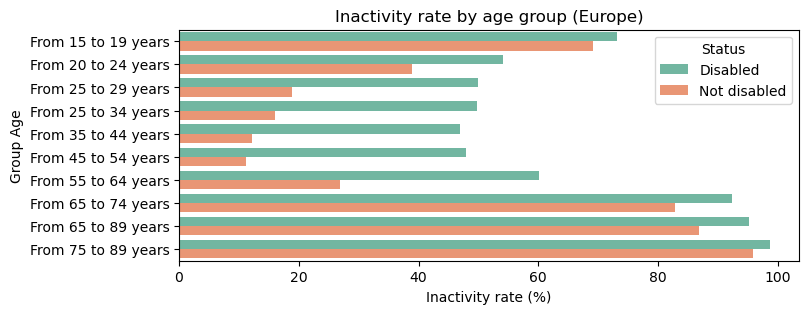

In [ ]:
# Map Disabled vs Not disabled
df_inactive_status = df_inactive.copy()
df_inactive_status["Disability_status"] = df_inactive_status["lev_limit"].replace({
    "Severe": "Disabled",
    "Some": "Disabled",
    "Some or severe": "Disabled",
    "None": "Not disabled"
})

# Disabled / Not disabled
df_inactive_status = df_inactive_status[df_inactive_status["Disability_status"].isin(["Disabled", "Not disabled"])]

# Average Age
df_grouped_age = df_inactive_status.groupby(["age", "Disability_status"])["value"].mean().reset_index()

# Barplot 
plt.figure(figsize=(8,3))
sns.barplot(
    data=df_grouped_age,
    x="value", y="age",
    hue="Disability_status", palette="Set2"
)
plt.title("Inactivity rate by age group (Europe)")
plt.xlabel("Inactivity rate (%)")
plt.ylabel("Group Age")
plt.legend(title="Status")
plt.show()


Here, the results are logical, the inactive people are the young and the senior people. 

The people with disabilities are more often inactive, especially between 25 and 64 years, during the the period of activity.

Top 5 countries with the highest inactivity rate (Disabled):
         geo Disability_status      value
6   Bulgaria          Disabled  96.009942
24    Greece          Disabled  92.328870
40     Malta          Disabled  92.170492
50   Romania          Disabled  88.403053
52    Serbia          Disabled  88.100683


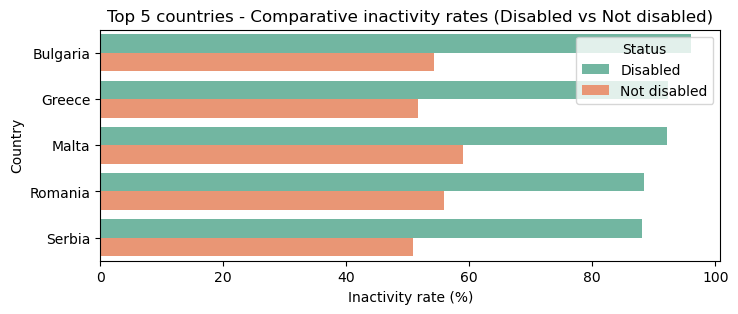

In [ ]:
# Disabled / Not 
df_inactive_status = df_inactive_status[df_inactive_status["Disability_status"].isin(["Disabled", "Not disabled"])]

# Average by country
df_grouped_country = df_inactive_status.groupby(
    ["geo", "Disability_status"]
)["value"].mean().reset_index()

# Sort : top 5 inactivity of disabled people
top5_disabled = (
    df_grouped_country[df_grouped_country["Disability_status"] == "Disabled"]
    .sort_values("value", ascending=False) 
    .head(5)
)

print("Top 5 countries with the highest inactivity rate (Disabled):")
print(top5_disabled)

# Barplot 
plt.figure(figsize=(8,3))
sns.barplot(
    data=df_grouped_country[df_grouped_country["geo"].isin(top5_disabled["geo"])],
    x="value", y="geo", hue="Disability_status", palette="Set2", order=top5_disabled["geo"]
)
plt.title("Top 5 countries - Comparative inactivity rates (Disabled vs Not disabled)")
plt.xlabel("Inactivity rate (%)")
plt.ylabel("Country")
plt.legend(title="Status")
plt.show()


For the inactive people, the largest percentage is found in **Bulgaria**. 

More gloablly, the highest rates of inactivity are in countries that are more in **Eastern Europe**.

Top 5 countries with the lowest inactivity rate (Disabled):
            geo Disability_status      value
62  Switzerland          Disabled  52.576718
42  Netherlands          Disabled  58.209242
18      Finland          Disabled  62.353866
14      Denmark          Disabled  63.131436
44       Norway          Disabled  65.039589


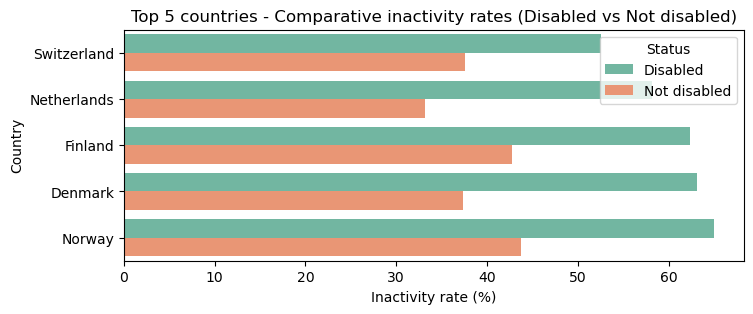

In [ ]:
# Sort low
top5_disabled = (
    df_grouped_country[df_grouped_country["Disability_status"] == "Disabled"]
    .sort_values("value", ascending=True) 
    .head(5)
)

print("Top 5 countries with the lowest inactivity rate (Disabled):")
print(top5_disabled)

# Barplot 
plt.figure(figsize=(8,3))
sns.barplot(
    data=df_grouped_country[df_grouped_country["geo"].isin(top5_disabled["geo"])],
    x="value", y="geo", hue="Disability_status", palette="Set2", order=top5_disabled["geo"]
)
plt.title("Top 5 countries - Comparative inactivity rates (Disabled vs Not disabled)")
plt.xlabel("Inactivity rate (%)")
plt.ylabel("Country")
plt.legend(title="Status")
plt.show()

## Gender based violence

Women who have experienced violence by any perpetrator, by level of disability (activity limitation)

In [34]:
# 1. Eurostat Data
dataset = "gbv_any_lim"
url = f"https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/{dataset}"
resp = requests.get(url)
data = resp.json()

# 2. Extraire les dimensions
dims = list(data["dimension"].keys())
categories = {
    dim: list(data["dimension"][dim]["category"]["index"].keys())
    for dim in dims
}

# 3. Créer toutes les combinaisons possibles des dimensions
combinations = list(itertools.product(*[categories[dim] for dim in dims]))

# 4. Construire le DataFrame brut
df_violence = pd.DataFrame(combinations, columns=dims)
df_violence["value"] = [data["value"].get(str(i), None) for i in range(len(combinations))]

# 5. Remplacer les codes par les labels lisibles
for dim in dims:
    labels = data["dimension"][dim]["category"]["label"]
    df_violence[dim] = df_violence[dim].map(labels)

df_violence.head(5)


,freq,lev_limit,unit,geo,time,value
0,Annual,Total,Percentage,European Union (aggregate changing according t...,2021,30.5
1,Annual,Total,Percentage,Belgium,2021,29.1
2,Annual,Total,Percentage,Bulgaria,2021,11.9
3,Annual,Total,Percentage,Czechia,2021,19.7
4,Annual,Total,Percentage,Denmark,2021,47.5


In [35]:
df_violence["lev_limit"].unique()

array(['Total', 'Some', 'Limited but not severely or not limited at all',
       'Severe', 'Some or severe', 'None'], dtype=object)

In [36]:
to_remove_geo_violence = [
    'European Union (aggregate changing according to the context)'
]
df_violence = df_violence[~df_violence["geo"].isin(to_remove_geo_violence)]

# Lev Limit
to_remove_lim_violence = [
    'Limited but not severely or not limited at all'
]
df_violence = df_violence[~df_violence["lev_limit"].isin(to_remove_lim_violence)]

  Disability_status      value
0          Disabled  41.102439
1      Not disabled  29.141379
2             Total  31.117241


/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_20721/2360068720.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


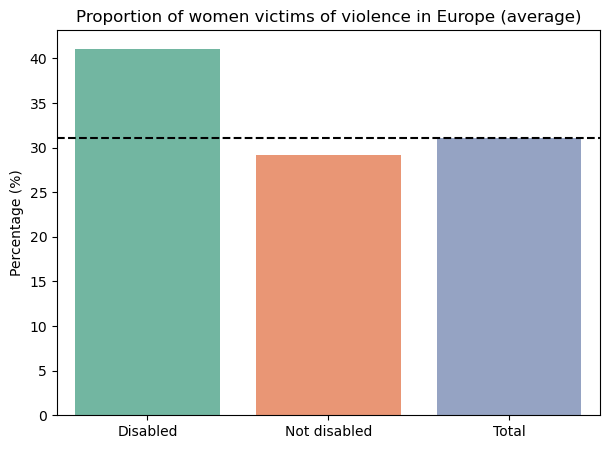

,Disability_status,value
0,Disabled,41.102439
1,Not disabled,29.141379
2,Total,31.117241


In [38]:
# Map Disabled vs Not disabled
df_violence_status = df_violence.copy()
df_violence_status["Disability_status"] = df_violence_status["lev_limit"].replace({
    "Severe": "Disabled",
    "Some": "Disabled",
    "Some or severe": "Disabled",
    "None": "Not disabled",
    "Total": "Total"
})

df_violence_status = df_violence_status[df_violence_status["Disability_status"].isin(["Disabled", "Not disabled", "Total"])]

# Average in Europe
df_avg = df_violence_status.groupby("Disability_status")["value"].mean().reset_index()

print(df_avg)

# Barplot
plt.figure(figsize=(7,5))
sns.barplot(
    data=df_avg,
    x="Disability_status",
    y="value",
    palette="Set2"
)

# Add a horizontal line for the total proportion
total_value = df_avg[df_avg["Disability_status"] == "Total"]["value"].values[0]
plt.axhline(total_value, color="black", linestyle="--", label=f"Average all women ({total_value:.1f}%)")

plt.title("Proportion of women victims of violence in Europe (average)")
plt.ylabel("Percentage (%)")
plt.xlabel("")
plt.show()


df_avg

- Total → gives the overall prevalence : 31%

- Disabled → higher → shows that women with disabilities are more exposed to violence : 41%

- Not disabled → measures the exposure gap : 29%

Disabled women are very vulnerable

Top 10 countries with the highest % of women with disabilities who are victims of violence :


,geo,Disability_status,value
16,Finland,Disabled,71.233333
56,Sweden,Disabled,64.700000
12,Denmark,Disabled,62.400000
34,Luxembourg,Disabled,59.366667
26,Ireland,Disabled,53.600000
46,Romania,Disabled,53.533333
24,Hungary,Disabled,51.700000
50,Slovakia,Disabled,51.666667
40,Netherlands,Disabled,51.366667
2,Belgium,Disabled,46.100000


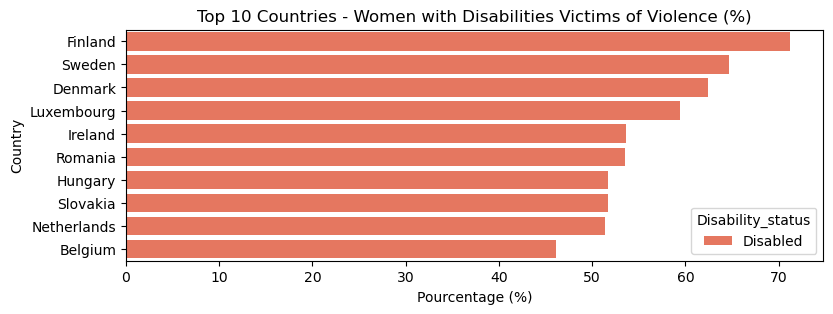

In [ ]:
df_country_violence = df_violence_status[df_violence_status["Disability_status"].isin(["Disabled", "Not disabled"])]

# Average by country
df_country_grouped_vio = df_country_violence.groupby(["geo", "Disability_status"])["value"].mean().reset_index()

# Sort by disabled womens
df_top_disabled_violence = df_country_grouped_vio[df_country_grouped_vio["Disability_status"] == "Disabled"] \
                    .sort_values("value", ascending=False).head(10)

# Top 10
print("Top 10 countries with the highest % of women with disabilities who are victims of violence :")
display(df_top_disabled_violence)

# Plot
plt.figure(figsize=(9,3))
sns.barplot(
    data=df_top_disabled_violence,
    x="value", 
    y="geo", 
    hue="Disability_status", 
    palette="Reds"
)
plt.title("Top 10 Countries - Women with Disabilities Victims of Violence (%)")
plt.xlabel("Pourcentage (%)")
plt.ylabel("Country")
plt.show()


Finland is where the disabled women are more exposed to violence. 

This may also reflect:

- better reporting and data collection (women speak out more, and surveys are more reliable),

- greater awareness of the issue,

- or indeed a more pronounced problem of violence.


Overall Summary :
- Disabled women in the dataset : 75.0%
- Women Not Disabled in the Dataset : 25.0%


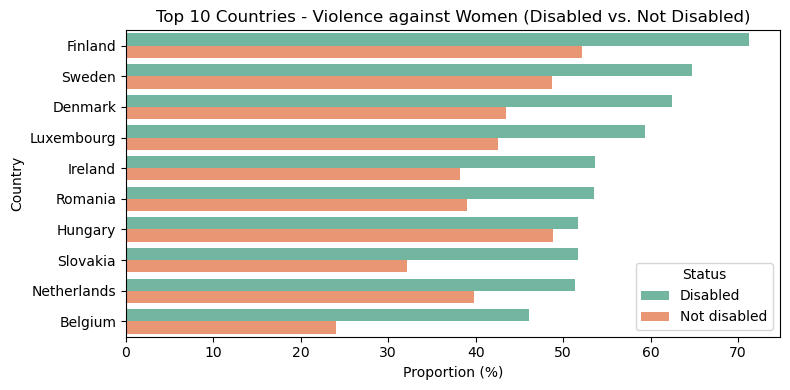

In [ ]:
# Disabled / not disabled
df_women_filtered = df_violence_status[df_violence_status["Disability_status"].isin(["Disabled", "Not disabled"])]

# Proportion
prop = df_women_filtered["Disability_status"].value_counts(normalize=True) * 100

# Average violence by country and status
df_country_grouped_gen = df_women_filtered.groupby(
    ["geo", "Disability_status"]
)["value"].mean().reset_index()

# Sort : Average Disabled by country 
df_disabled = df_country_grouped_gen[df_country_grouped_gen["Disability_status"] == "Disabled"]
top10_countries = df_disabled.sort_values("value", ascending=False).head(10)["geo"]

# Top 10 
df_top10 = df_country_grouped_gen[df_country_grouped_gen["geo"].isin(top10_countries)]

# Summary
print("\nOverall Summary :")
print(f"- Disabled women in the dataset : {prop['Disabled']:.1f}%")
print(f"- Women Not Disabled in the Dataset : {prop['Not disabled']:.1f}%")

# Plot
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_top10,
    x="value",
    y="geo",
    hue="Disability_status",
    palette="Set2",
    order=top10_countries 
)
plt.title("Top 10 Countries - Violence against Women (Disabled vs. Not Disabled)")
plt.xlabel("Proportion (%)")
plt.ylabel("Country")
plt.legend(title="Status")
plt.tight_layout()
plt.show()

Top 5 countries with the highest gap (Disabled – Not disabled):
Disability_status       geo   Disabled  Not disabled        Gap
1                   Belgium  46.100000          24.0  22.100000
10                  Germany  43.300000          22.7  20.600000
25                 Slovakia  51.666667          32.2  19.466667
2                  Bulgaria  28.833333           9.5  19.333333
8                   Finland  71.233333          52.1  19.133333


/var/folders/zv/n5tftmvs15g6v9bt94cd5v400000gn/T/ipykernel_12591/1220888546.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


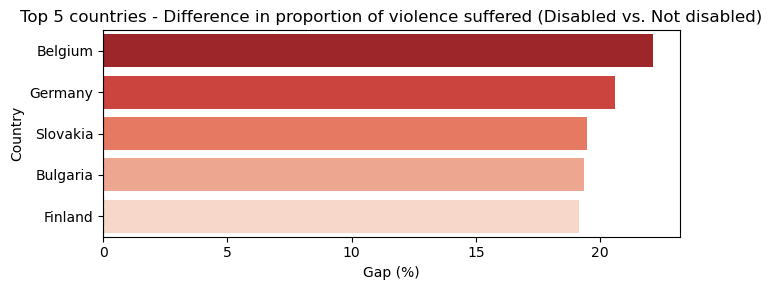

In [ ]:
# Pivot Disabled vs Not disabled
df_pivot_violence = df_country_grouped_gen.pivot(index="geo", columns="Disability_status", values="value").reset_index()

# Gap
df_pivot_violence["Gap"] = df_pivot_violence["Disabled"] - df_pivot_violence["Not disabled"]

# Top 10 countries with the highest gap
df_top5_gap_violence = df_pivot_violence.sort_values("Gap", ascending=False).head(5)
print("Top 5 countries with the highest gap (Disabled – Not disabled):")
print(df_top5_gap_violence[["geo", "Disabled", "Not disabled", "Gap"]])

# Plot
plt.figure(figsize=(7,3))
sns.barplot(
    data=df_top5_gap_violence,
    x="Gap",
    y="geo",
    palette="Reds_r"
)
plt.title("Top 5 countries - Difference in proportion of violence suffered (Disabled vs. Not disabled)")
plt.xlabel("Gap (%)")
plt.ylabel("Country")
plt.axvline(0, color="black", linestyle="--")
plt.tight_layout()
plt.show()

This is the gap between violence against women without disabilities and those with disabilities, to show how much more vulnerable disabled women are.

**Belgium** is the first country with the highest gap. 

The 22.1-point gap shows that women with disabilities are much more exposed than others.

This can be interpreted as an increased risk : they are nearly twice as likely to be victims as women without disabilities (here, 46% vs. 24%).

----------------

# SQL

In [ ]:
import pymysql
from sqlalchemy import create_engine, text

# Connexion
user = 'root'
password = 'Muxumonlapin2607'
host = 'localhost'
port = 3306
database = 'data_analytics_project'

# Conectarse al servidor (sin base de datos específica)
engine_server = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/mysql')
with engine_server.connect() as conn:
    conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {database}"))
    print(f"Database '{database}' created or already exists.")

# Conectarse a la base de datos recién creada
engine_db = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

# Exportar DataFrame a MySQL
df_violence.to_sql('violence', engine_db, if_exists='replace', index=False)
print("Table 'violence' created successfully in MySQL!")

Database 'data_analytics_project' created or already exists.
Table 'violence' created successfully in MySQL!


In [ ]:
# General 

df.to_sql('general', engine_db, if_exists='replace', index=False)
print("Table 'general' created successfully in MySQL!")

Table 'general' created successfully in MySQL!


In [ ]:
# Education

df_edu_clean.to_sql('education', engine_db, if_exists='replace', index=False)
print("Table 'education' created successfully in MySQL!")

Table 'education' created successfully in MySQL!


In [ ]:
# Education Young 

#df_edu_young_clean.to_sql('education_young', engine_db, if_exists='replace', index=False)
#print("Table 'education_young' created successfully in MySQL!")


In [ ]:
# Cultural 

#df_merged_cultural.to_sql('cultural', engine_db, if_exists='replace', index=False)
#print("Table 'cultural' created successfully in MySQL!")

In [ ]:
# Feeling Left Out 

#df_out.to_sql('left_out', engine_db, if_exists='replace', index=False)
#print("Table 'left_out' created successfully in MySQL!")

In [ ]:
# Social Support 

#df_support.to_sql('social_support', engine_db, if_exists='replace', index=False)
#print("Table 'social_support' created successfully in MySQL!")

In [ ]:
# Poverty 

#df_poverty.to_sql('poverty', engine_db, if_exists='replace', index=False)
#print("Table 'poverty' created successfully in MySQL!")

In [ ]:
# Labour Market

# Disability employment gap by level of activity limitation and sex
#df_labourm.to_sql('employment_gap', engine_db, if_exists='replace', index=False)
#print("Table 'employment_gap' created successfully in MySQL!")

In [ ]:
# Employment by level of disability (activity limitation) and occupation
#df_employment.to_sql('employment', engine_db, if_exists='replace', index=False)
#print("Table 'employment' created successfully in MySQL!")

In [ ]:
# Unemployment rates by level of disability (activity limitation) and educational attainment level
#df_unemployment.to_sql('unemployment', engine_db, if_exists='replace', index=False)
#print("Table 'unemployment' created successfully in MySQL!")

In [ ]:
# Inactive population by level of disability (activity limitation) and educational attainment level - % of total population
#df_inactive.to_sql('inactive', engine_db, if_exists='replace', index=False)
#print("Table 'inactive' created successfully in MySQL!")

--------

# Export CSV 

In [26]:
# Education 

df_edu_clean.to_csv("education.csv", sep=";", index=False, encoding="utf-8")

In [45]:
df_merged_cultural.to_csv("cultural.csv", sep=";", index=False, encoding="utf-8")

In [7]:
df_employment.to_csv("employment.csv", sep=";", index=False, encoding="utf-8")

__________

## ASD children traits

Explore whether a child develops ASD traits in future through this dataset

In [ ]:
df_asd_children = pd.read_csv("/Users/lucielopez/Desktop/stuff/IRONHACK/PROJECT/FINAL PROJECT/ASD children traits.csv")
df_asd_children

,CASE_NO_PATIENT'S,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,Global developmental delay/intellectual disability,Social/Behavioural Issues,Childhood Autism Rating Scale,Anxiety_disorder,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who_completed_the_test,ASD_traits
0,1,0,0,0,0,0,0,1,1,0,...,Yes,Yes,1,Yes,F,middle eastern,Yes,No,Family Member,No
1,2,1,1,0,0,0,1,1,0,0,...,Yes,Yes,2,Yes,M,White European,Yes,No,Family Member,Yes
2,3,1,0,0,0,0,0,1,1,0,...,Yes,Yes,4,Yes,M,Middle Eastern,Yes,No,Family Member,Yes
3,4,1,1,1,1,1,1,1,1,1,...,Yes,Yes,2,Yes,M,Hispanic,No,No,Family Member,Yes
4,5,1,1,0,1,1,1,1,1,1,...,Yes,Yes,1,Yes,F,White European,No,No,Family Member,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,1981,0,0,0,0,0,0,0,0,0,...,No,No,1,No,M,Middle Eastern,No,No,Health Care Professional,No
1981,1982,0,0,0,0,0,0,0,0,0,...,No,No,1,No,F,south asian,No,No,Health Care Professional,No
1982,1983,0,0,0,0,0,0,0,0,0,...,No,No,1,No,M,White European,No,No,Health Care Professional,Yes
1983,1984,0,0,0,0,0,0,0,0,0,...,No,No,1,No,M,Middle Eastern,No,No,Health Care Professional,No


predict disability

focus one disability : down, autism, rare diseases

---------------

## Insights

These results call for strengthened public policy efforts:

- improving the accessibility of infrastructure and services,

- promoting inclusion in education, employment, culture, and sport,

- fighting discrimination and invisible barriers to social participation.